# JamUNet model trained with the spatial dataset - testing and visualisation

This notebook was used for testing the model, computing the metric scores, and visualising the predictions.

In [1]:
%cd /workspace/jamunet-morpho-braided

/workspace/jamunet-morpho-braided


In [2]:
# reload modules to avoid restarting the notebook every time these are updated

%load_ext autoreload
%autoreload 2

In [3]:
# import modules 

import torch 
import copy
import time

from torch.utils.data import DataLoader

from model.train_eval import * 
from preprocessing.dataset_generation import create_full_dataset

from postprocessing.metrics import *
from postprocessing.plot_results import *
from postprocessing.save_results import load_model

# Enable interactive widgets in Jupyter Notebook
%matplotlib inline
%matplotlib widget

In [4]:
# set the device where operations are performed
# if only one GPU is present you might need to remove the index "0" 
# torch.device('cuda:0') --> torch.device('cuda') / torch.cuda.get_device_name(0) --> torch.cuda.get_device_name() 

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("CUDA Device Count: ", torch.cuda.device_count())
    print("CUDA Device Name: ", torch.cuda.get_device_name(0))
else:
    device = 'cpu'
    
print(f'Using device: {device}')

CUDA Device Count:  1
CUDA Device Name:  NVIDIA A40
Using device: cuda:0


In [5]:
# set common keys required for functions

train = 'training'
val = 'validation'
test = 'testing'

In [6]:
# load all datasets

# by default March images are used - if another month is used change the number (available months: 1-4)
dataset_path = r'data/satellite/dataset_month3' 

dtype=torch.float32

val_set = create_full_dataset(val, dir_folders=dataset_path, device=device, dtype=dtype)
test_set = create_full_dataset(test, dir_folders=dataset_path, device=device, dtype=dtype)

/root/miniconda3/envs/braided/lib/python3.9/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


**<span style="color:red">Attention!</span> Always remember to load the correct <code>save_path</code> file before running the following cells, in order to match all keys successfully when loading the model.**

In [7]:
# load model with min val loss

save_path_loss = rf'model/models_trained/UNet3D_spatial_bloss_month3_4dwns_8ihiddim_3ker_maxpool_0.05ilr_15step_0.75gamma_16batch_100epochs_0.5wthr.pth'

In [8]:
# load model with max recall

save_path_recall = rf'model/models_trained/UNet3D_spatial_brecall_month3_4dwns_8ihiddim_3ker_maxpool_0.05ilr_15step_0.75gamma_16batch_100epochs_0.5wthr.pth'

In [9]:
# load JamUNet architecture

from model.st_unet.st_unet import *

n_channels = test_set[0][0].shape[0]
n_classes = 1
init_hid_dim = 8
kernel_size = 3
pooling = 'max'
print(f'size n_channels {n_channels}')
model_loss = UNet3D(n_channels=n_channels, n_classes=n_classes, init_hid_dim=init_hid_dim, 
                         kernel_size=kernel_size, pooling=pooling, bilinear=False, drop_channels=False).to(device)

size n_channels 4


In [14]:
# deepcopy the model to avoid overwriting

model_recall = copy.deepcopy(model_loss)

In [15]:
loss_f = 'BCE'
batch_size = 16

# dataloaders to input data to the model in batches -- see note above

val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [16]:
# load model with min val loss

load_model(model_loss, save_path_loss, device=device)

<All keys matched successfully>

In [17]:
sample = 15

input_img = test_set[sample][0].unsqueeze(0).to(device)
target_img = test_set[sample][1].to(device)

prediction = model_loss(input_img).detach().to(device)
# check that the predictions from the same sample are different from those of the max recall model
print(prediction) 

tensor([[[[0.0242, 0.0093, 0.0113,  ..., 0.0124, 0.0110, 0.0471],
          [0.0049, 0.0012, 0.0018,  ..., 0.0021, 0.0016, 0.0101],
          [0.0057, 0.0014, 0.0025,  ..., 0.0028, 0.0021, 0.0119],
          ...,
          [0.0036, 0.0007, 0.0009,  ..., 0.0017, 0.0013, 0.0089],
          [0.0041, 0.0008, 0.0011,  ..., 0.0018, 0.0014, 0.0096],
          [0.0122, 0.0043, 0.0050,  ..., 0.0072, 0.0060, 0.0239]]]],
       device='cuda:0')


In [18]:
# load model with max recall

load_model(model_recall, save_path_recall, device=device)

<All keys matched successfully>

In [19]:
sample = 15

input_img = test_set[sample][0].unsqueeze(0).to(device)
target_img = test_set[sample][1].to(device)

prediction = model_recall(input_img).detach().to(device)
# check that the predictions from the same sample are different from those of the min loss model
print(prediction)

tensor([[[[0.0244, 0.0086, 0.0104,  ..., 0.0112, 0.0101, 0.0461],
          [0.0050, 0.0012, 0.0018,  ..., 0.0020, 0.0015, 0.0100],
          [0.0056, 0.0013, 0.0024,  ..., 0.0026, 0.0020, 0.0118],
          ...,
          [0.0035, 0.0007, 0.0009,  ..., 0.0021, 0.0015, 0.0102],
          [0.0041, 0.0008, 0.0011,  ..., 0.0022, 0.0018, 0.0112],
          [0.0124, 0.0045, 0.0054,  ..., 0.0090, 0.0076, 0.0279]]]],
       device='cuda:0')


In [20]:
# load losses and metrics saved during training and validation for plotting

losses_metrics = load_losses_metrics(r'model/losses_metrics/UNet3D_spatial_losses&metrics_month3_4dwns_8ihiddim_3ker_maxpool_0.05ilr_15step_0.75gamma_16batch_100epochs_0.5wthr.csv')
train_losses, val_losses = losses_metrics['Training loss'], losses_metrics['Validation loss']
metrics = [losses_metrics[losses_metrics.columns[i]].tolist() for i in range(2, len(losses_metrics.columns))]

In [21]:
plot_losses_metrics(train_losses, val_losses, metrics, model_recall, loss_f=loss_f, save_name='test')

In [22]:
total_losses_metrics_dataset(model_loss, test_set, device=device)

0.20761839


([tensor(0.1747), tensor(0.2406)],
 [0.917282625, 0.8946444615384616],
 [0.6303804577359136, 0.5464361074594668],
 [0.6241171880955477, 0.537723632465251],
 [0.6272331877542305, 0.5420448625655107],
 [0.4569116780497573, 0.3717843221975453])

In [23]:
# total_losses_metrics_dataset(model_recall, test_set, model_type='max recall', device=device)
total_losses_metrics_dataset(model_recall, test_set, device=device)

0.22589302


([tensor(0.1856), tensor(0.2662)],
 [0.91478375, 0.8886386153846154],
 [0.6007197207705629, 0.516887605720837],
 [0.703066916581842, 0.6059637093136189],
 [0.6478761934080284, 0.5578924416207722],
 [0.4791544903280716, 0.38685910657578315])

In [24]:
# check metrics with optimal threshold according to ROC and PR curves

new_thr = 0.402
total_losses_metrics_dataset(model_loss, test_set, water_threshold=new_thr, device=device)
# total_losses_metrics_dataset(model_recall, test_set, water_threshold=new_thr, model_type='max recall', device=device)
total_losses_metrics_dataset(model_recall, test_set, water_threshold=new_thr, device=device)

0.20761839
0.22589302


([tensor(0.1856), tensor(0.2662)],
 [0.910731125, 0.8815803076923077],
 [0.5746197595019225, 0.4921387532599957],
 [0.7678098193346456, 0.6659908822171391],
 [0.6573137253302456, 0.5660159491935194],
 [0.48955123600404554, 0.39471565173628587])

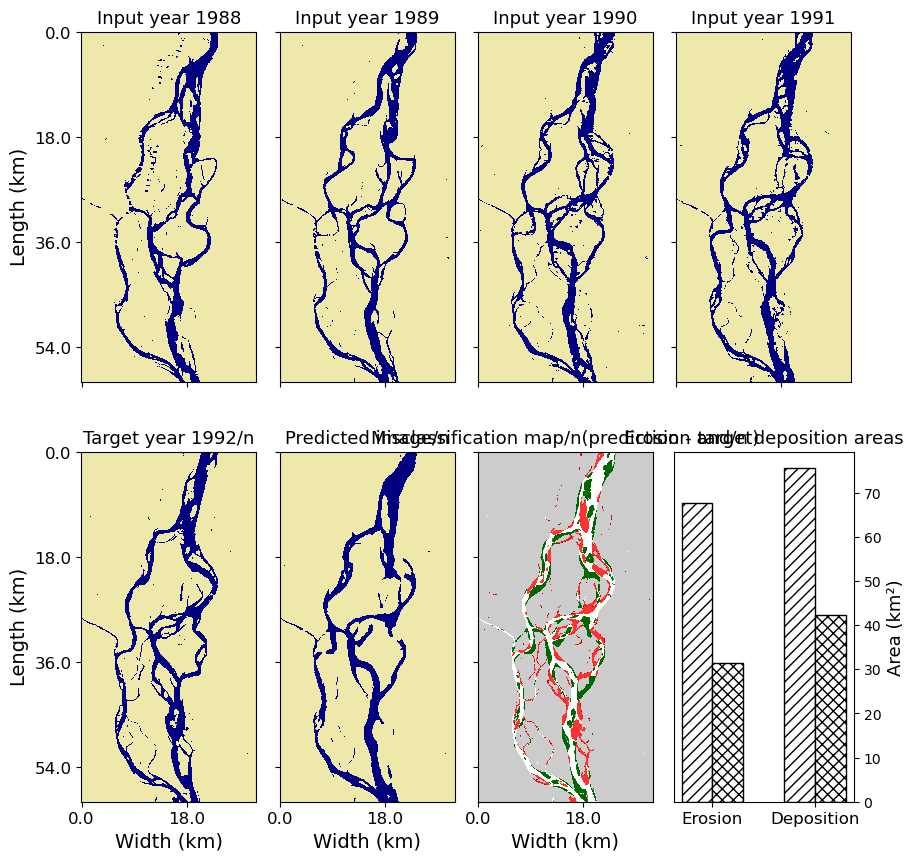

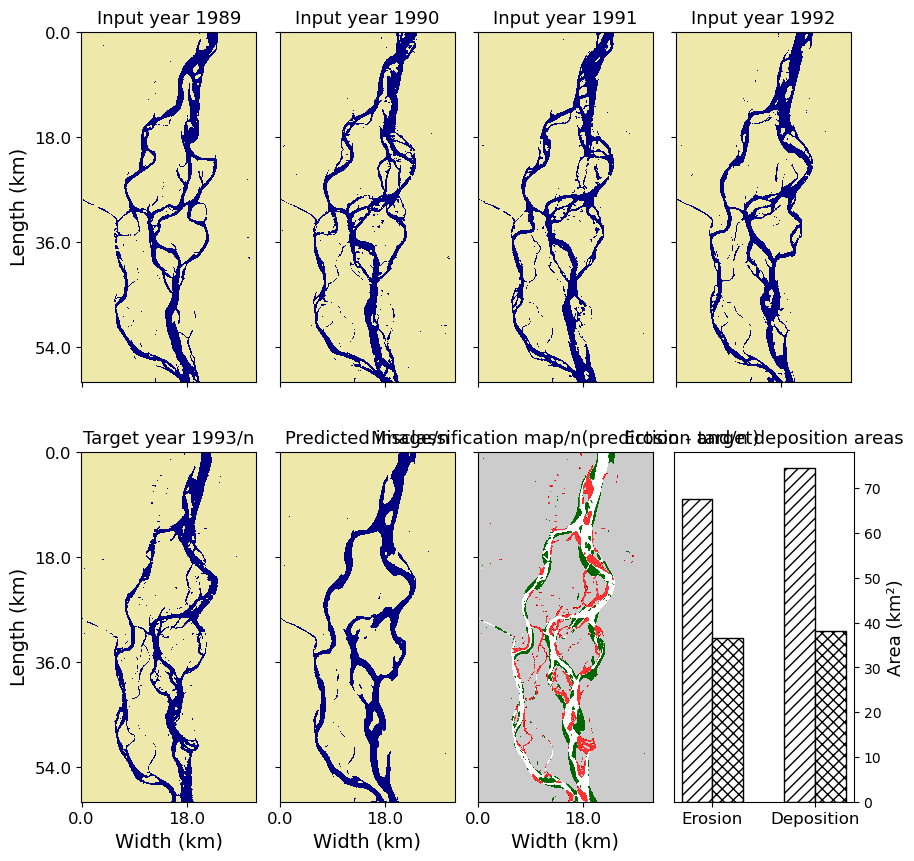

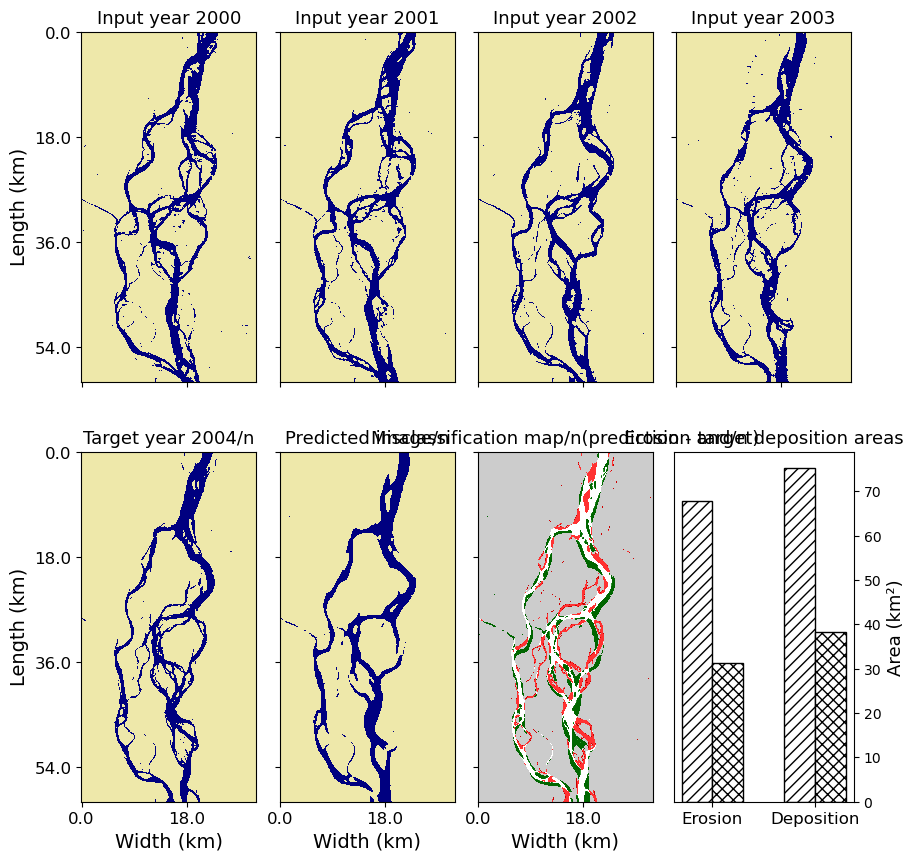

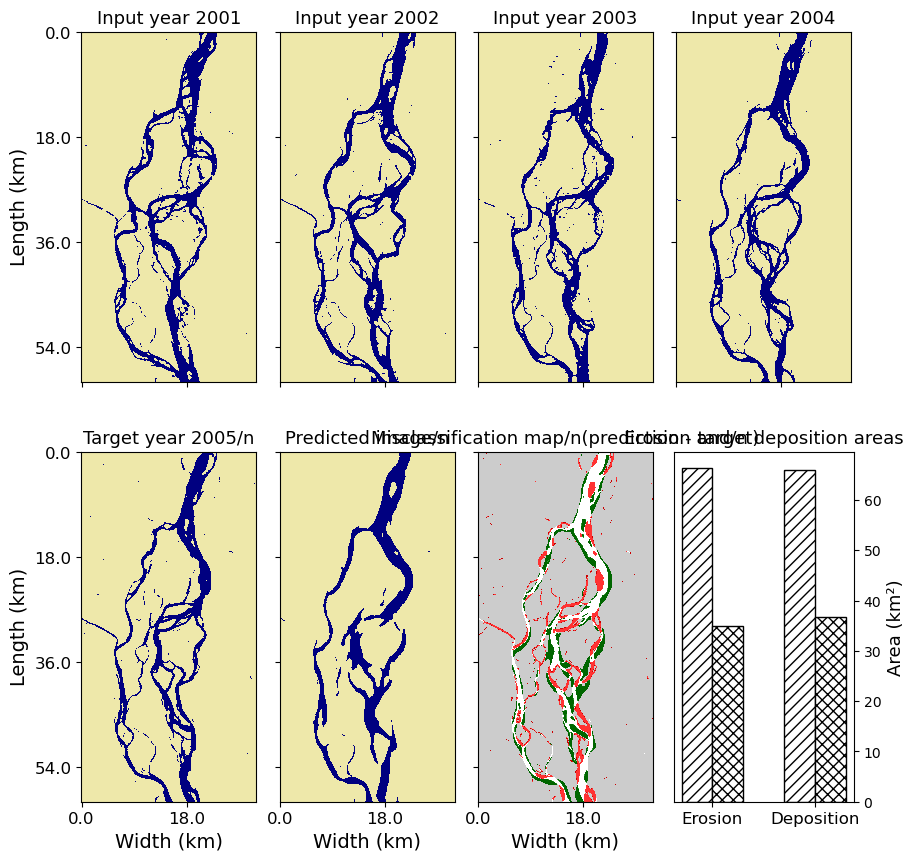

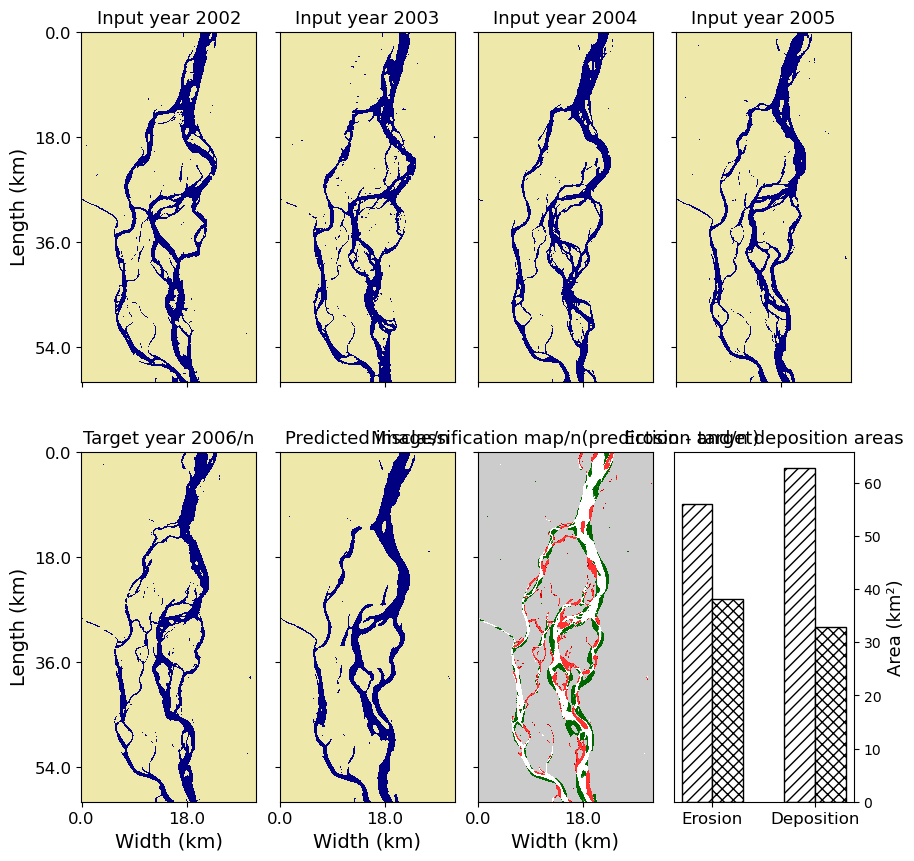

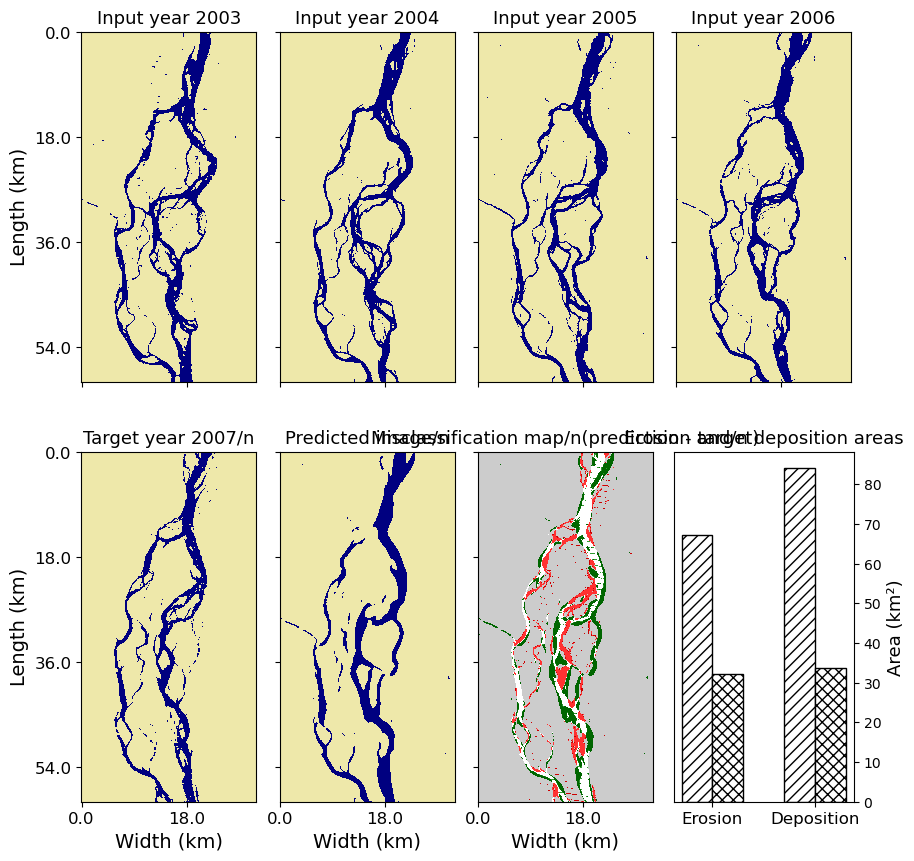

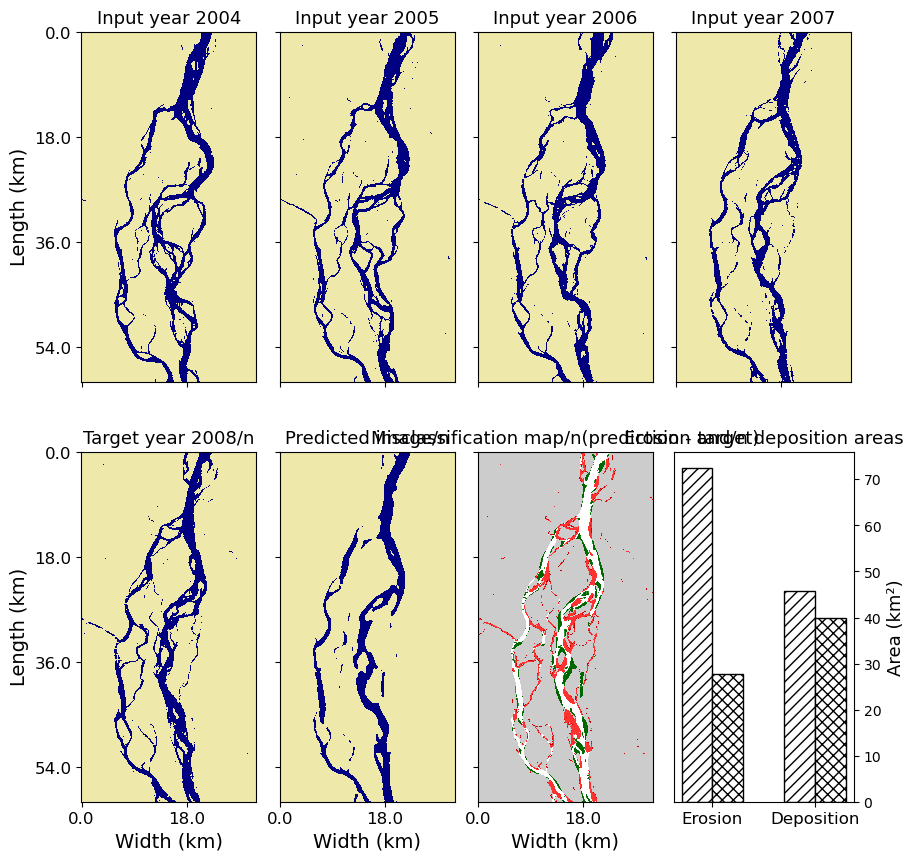

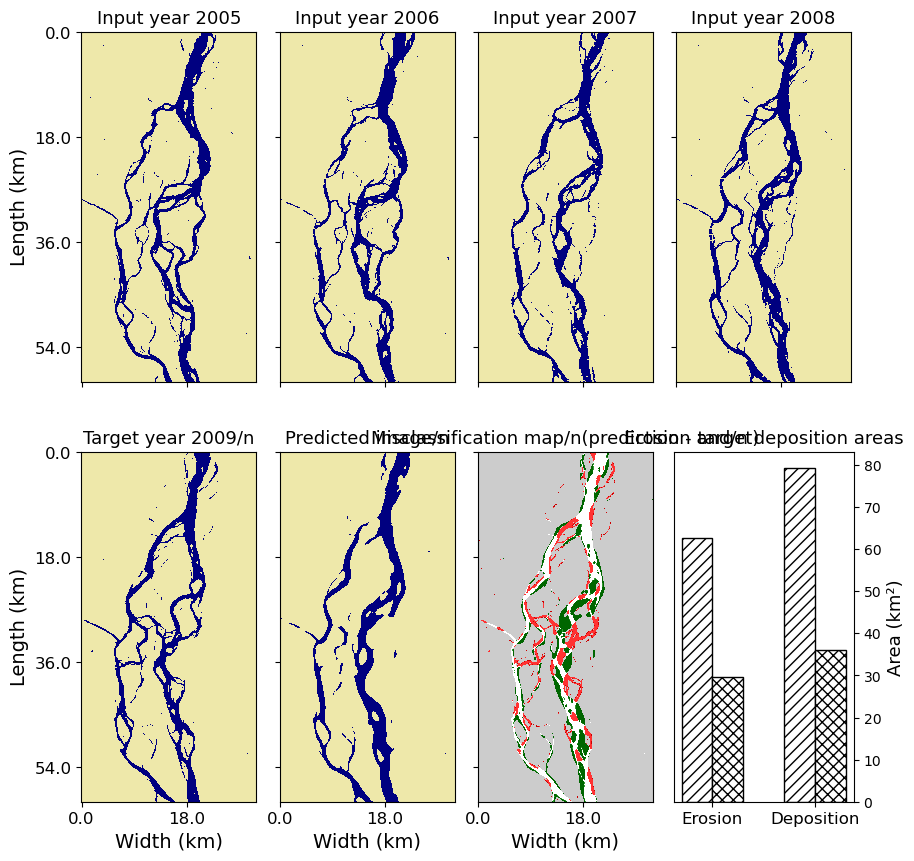

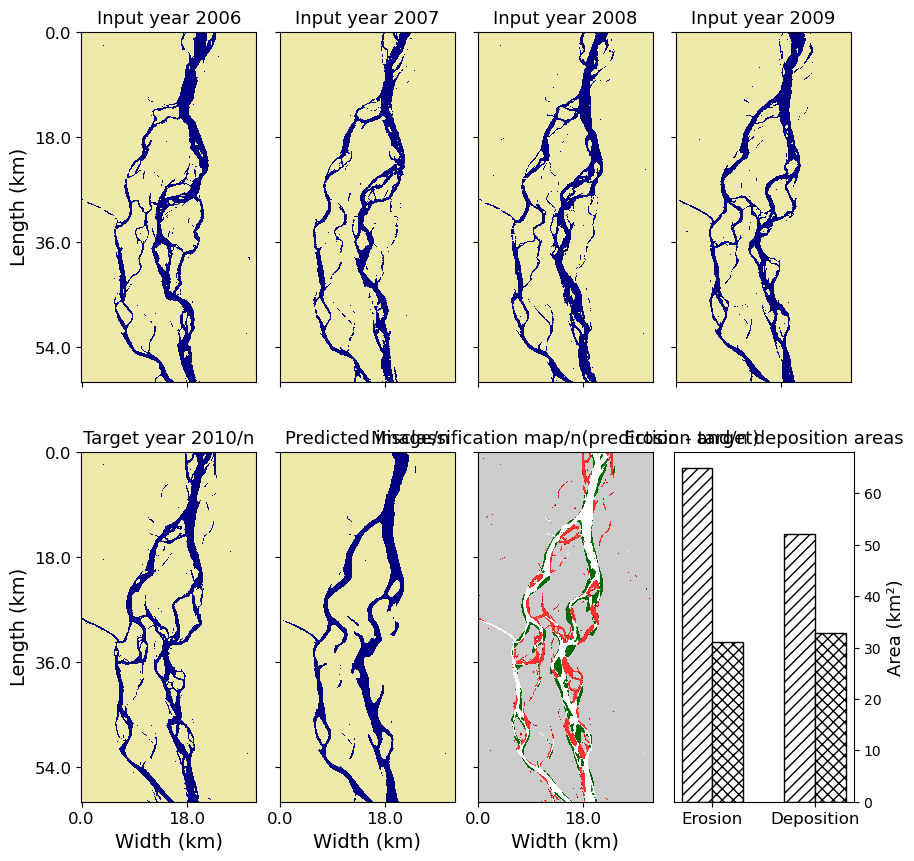

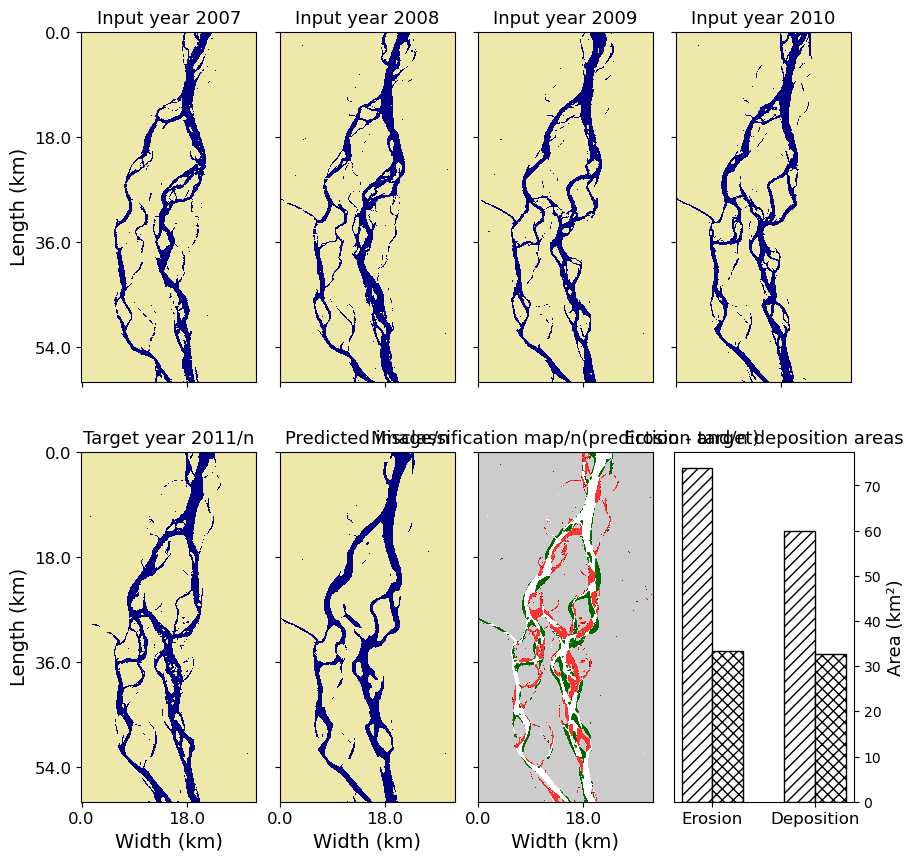

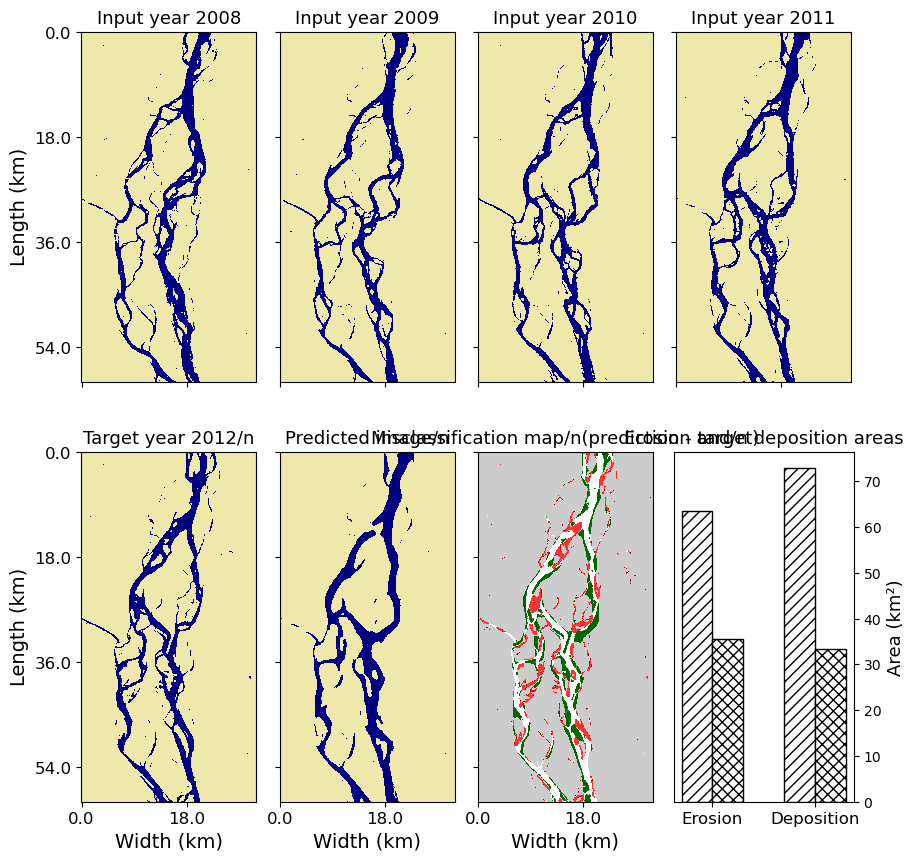

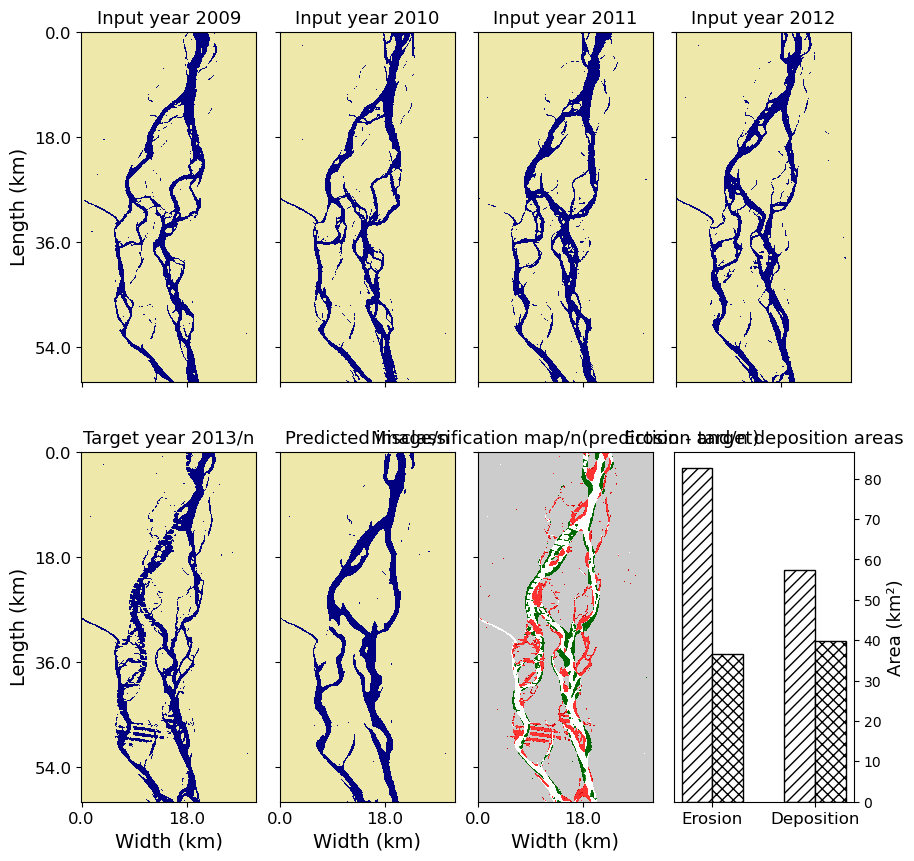

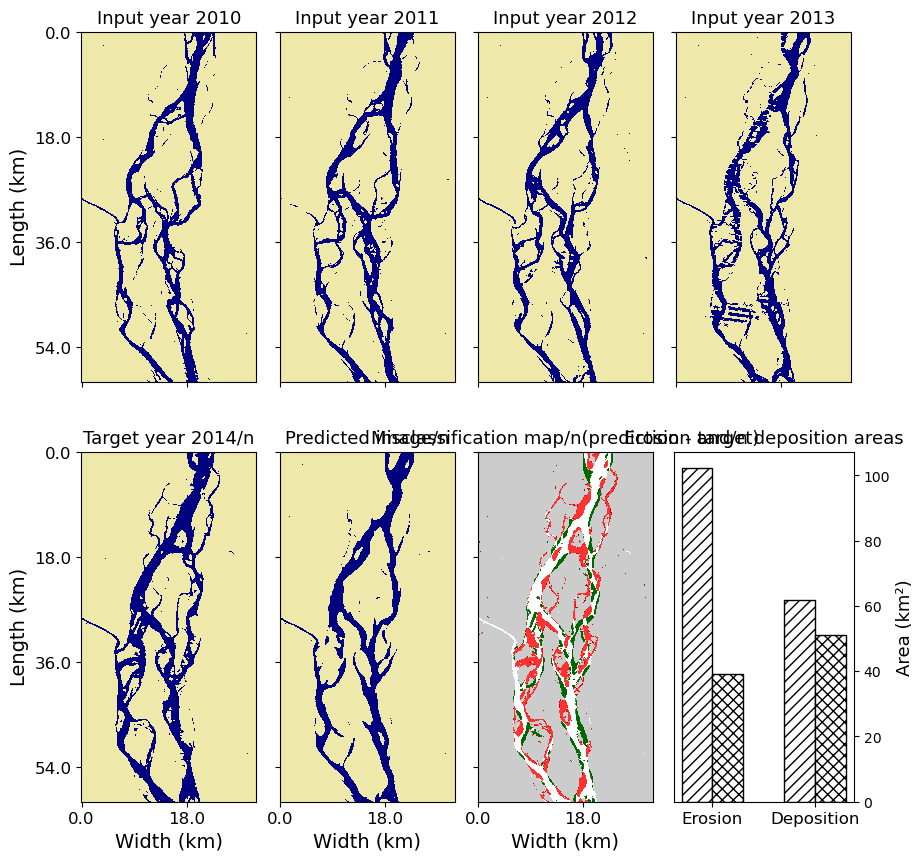

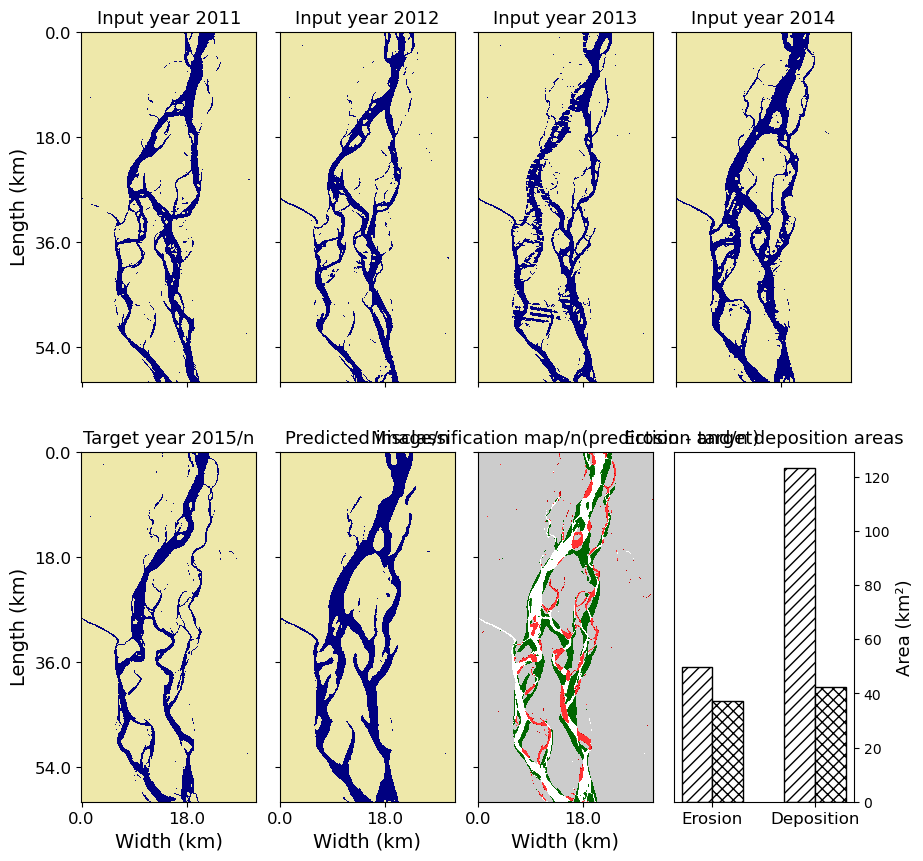

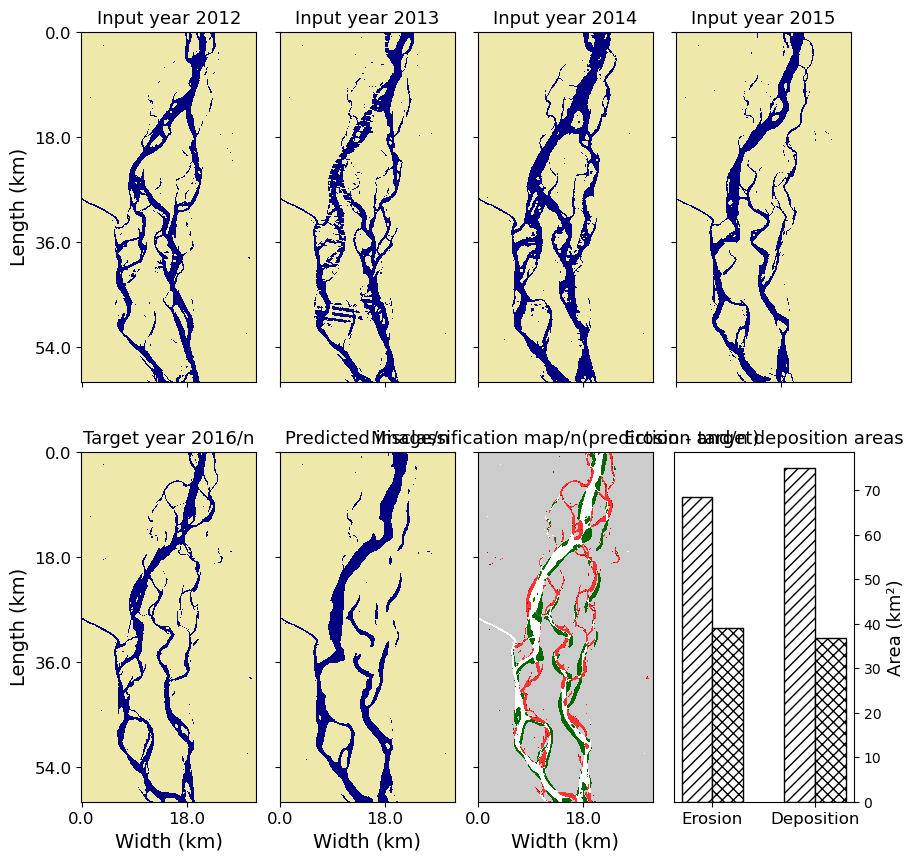

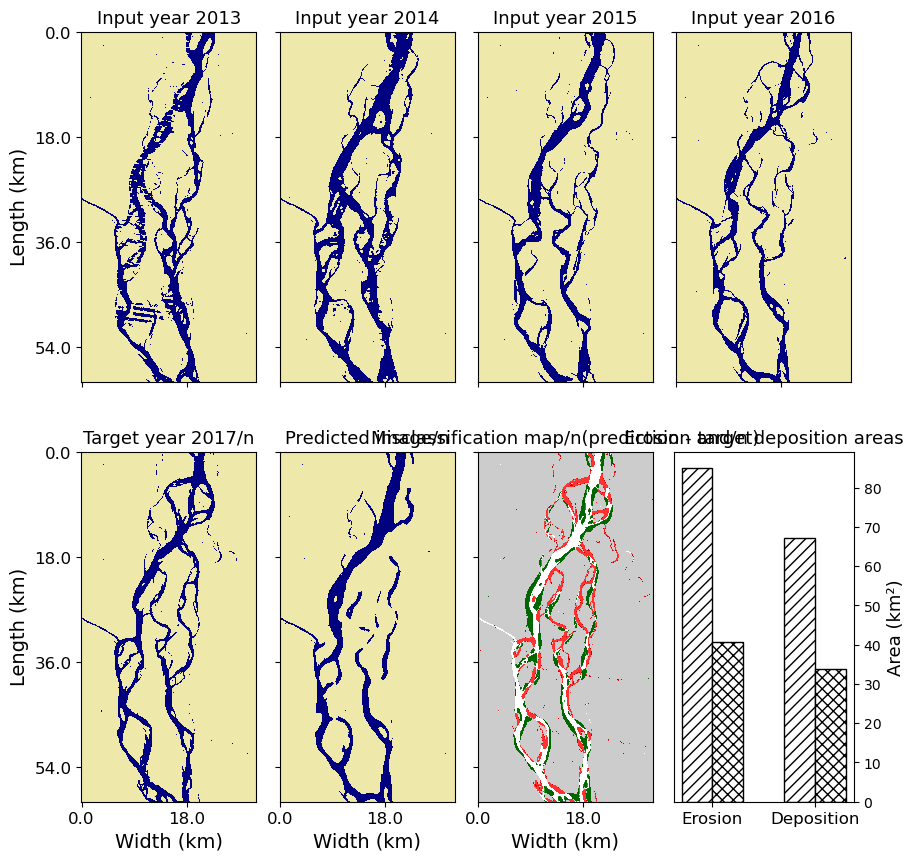

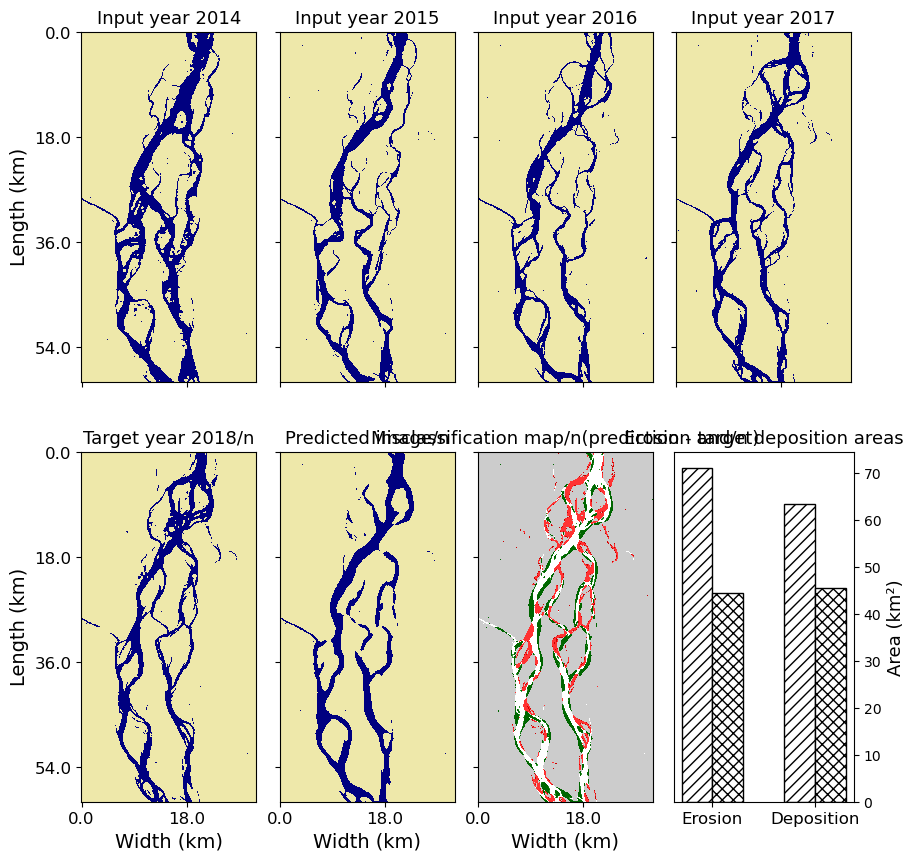

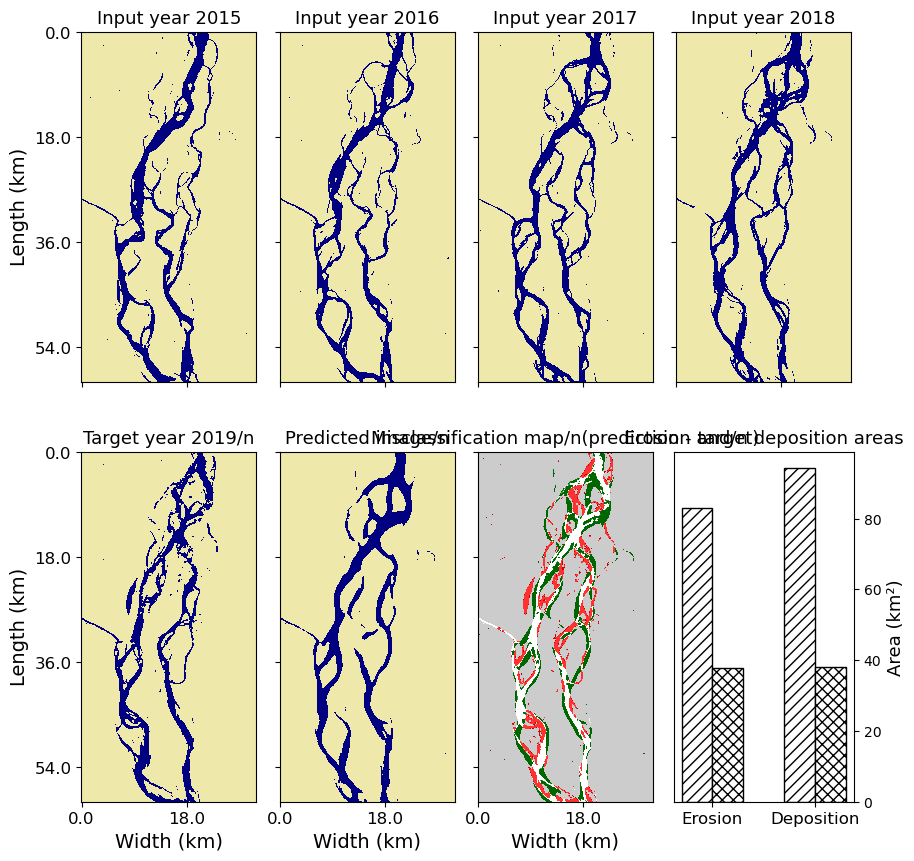

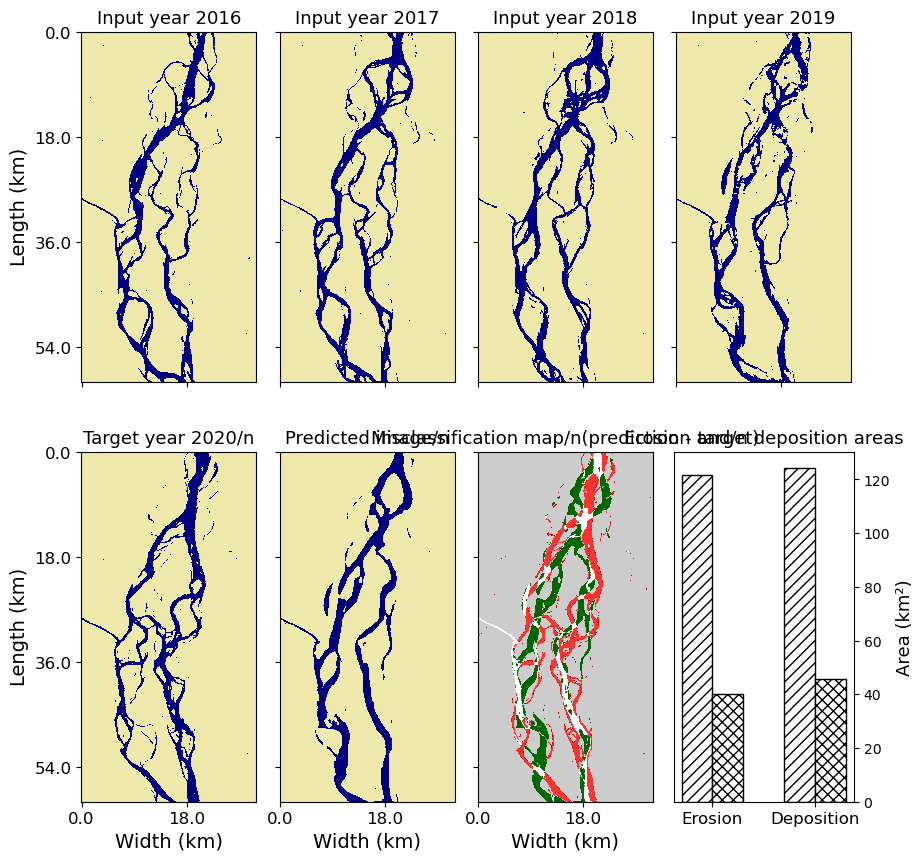

IndexError: list index out of range

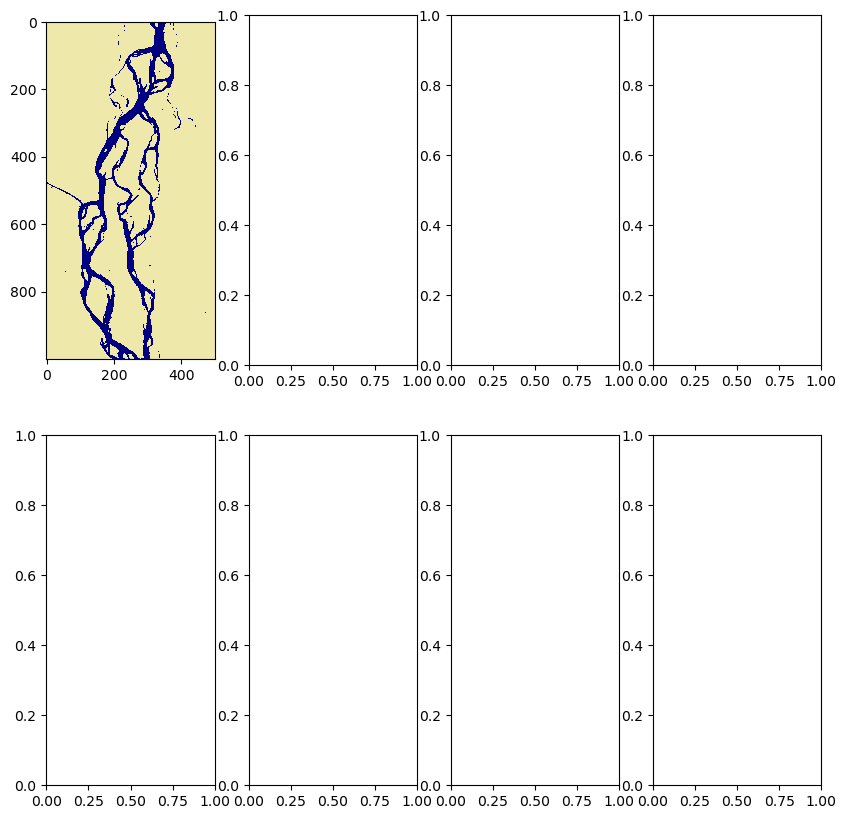

In [25]:
%matplotlib inline
for i in range(len(test_set)):
    show_evolution_nolegend(i, test_set, model_loss, device=device, save_img=False)

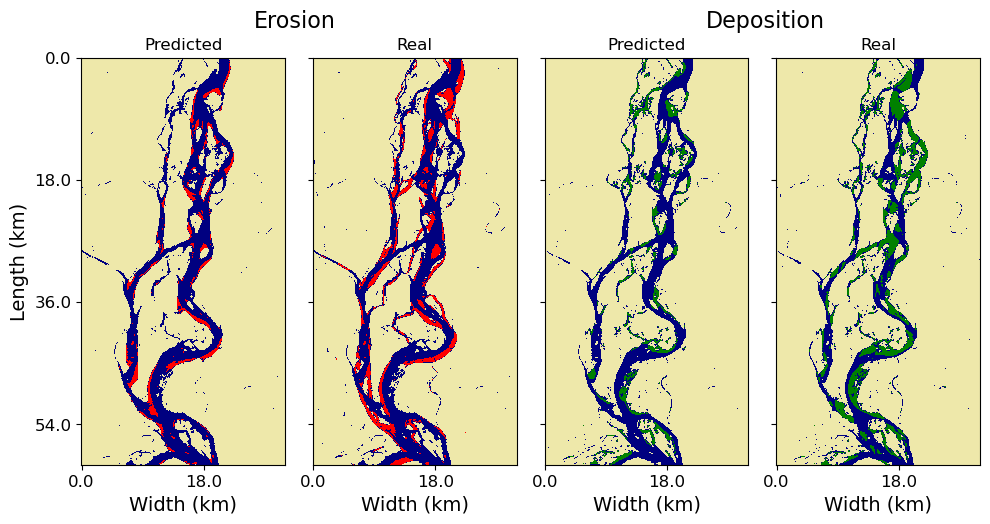

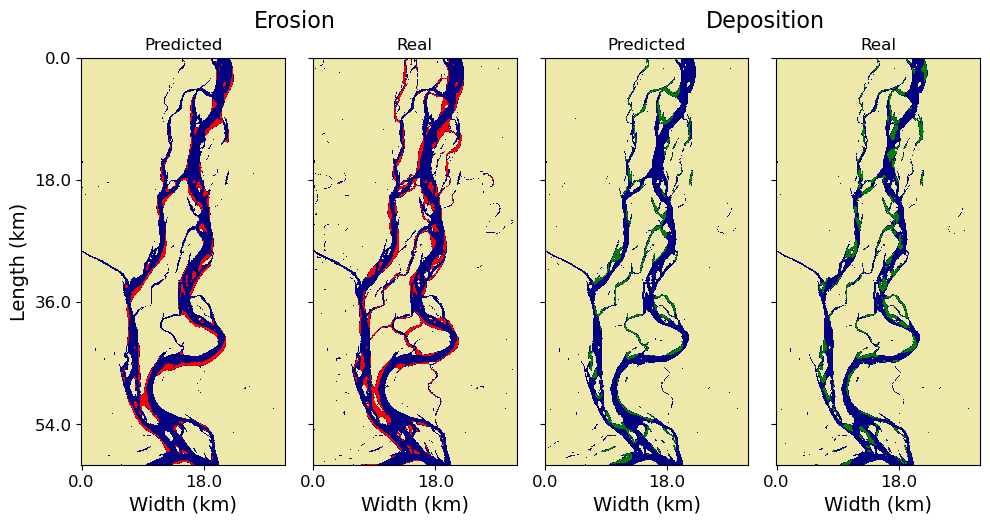

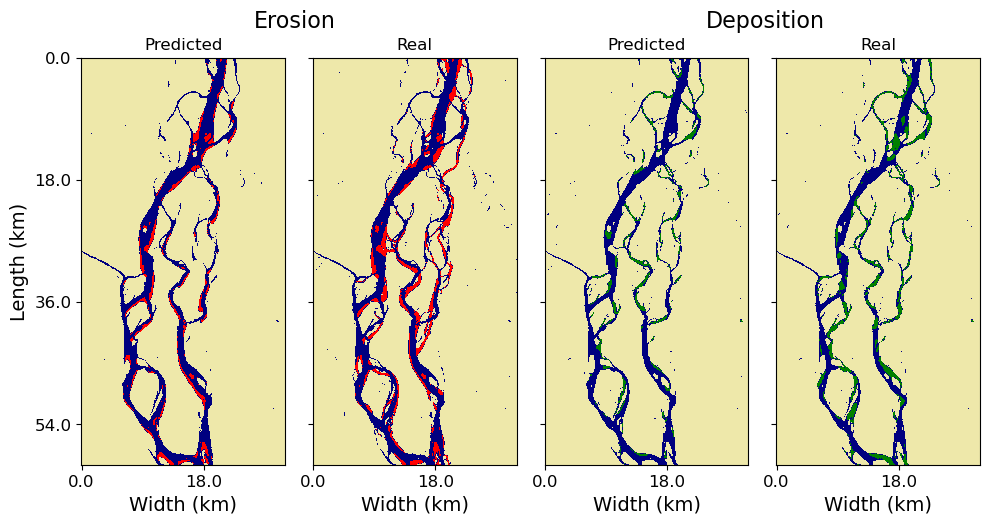

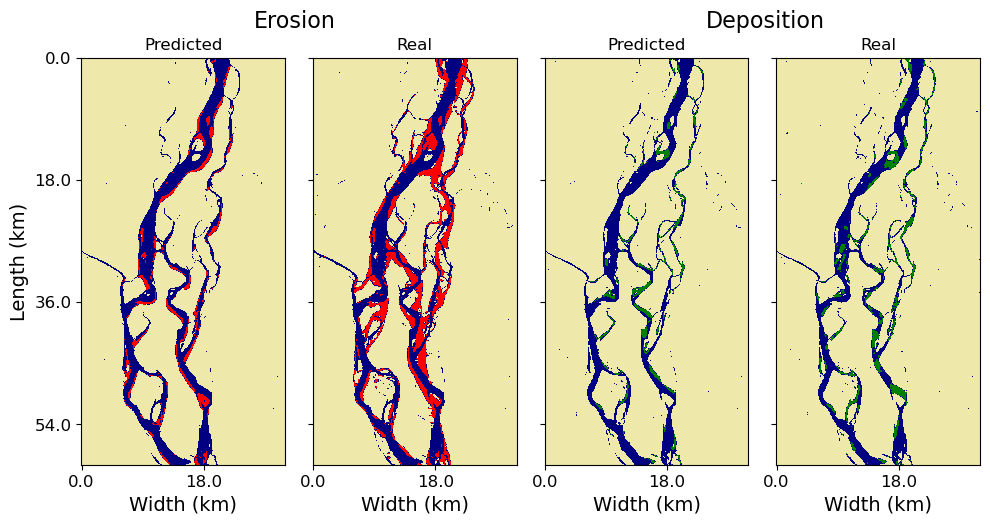

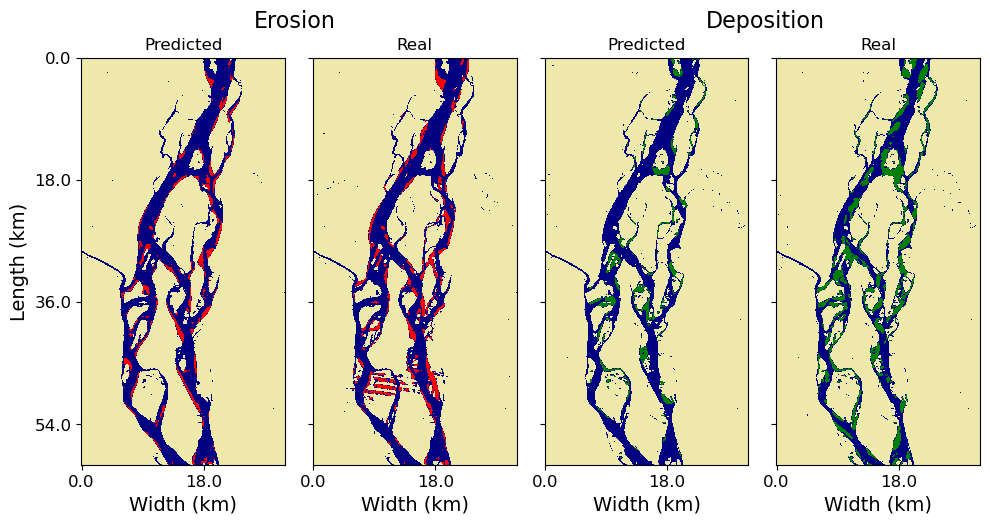

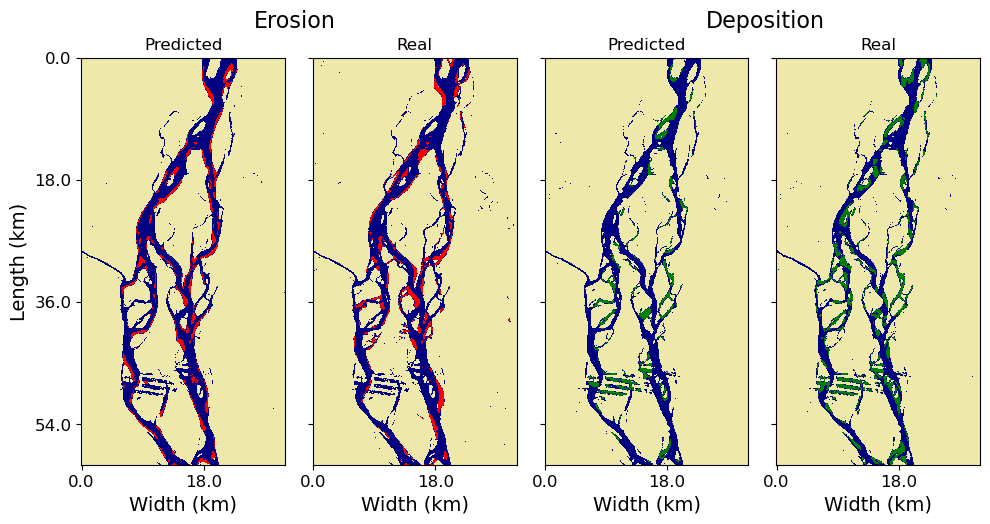

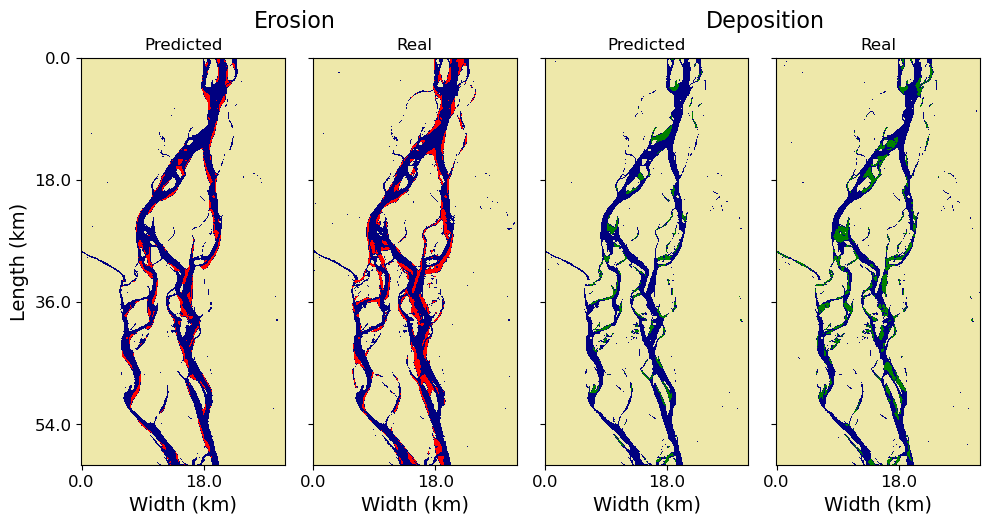

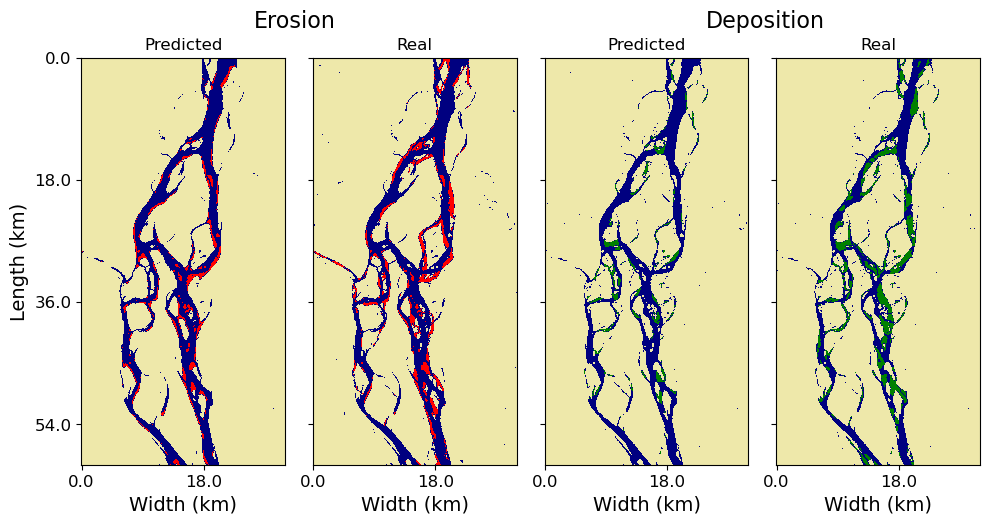

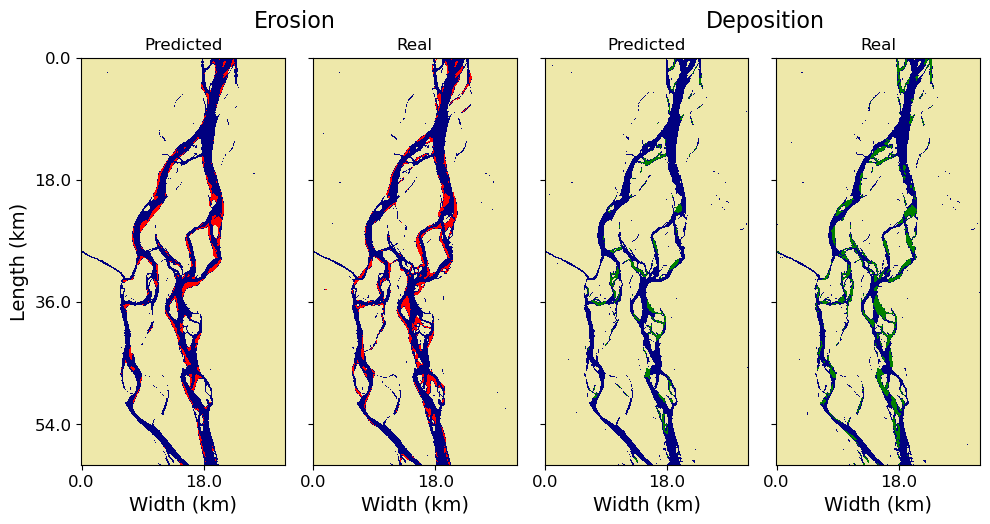

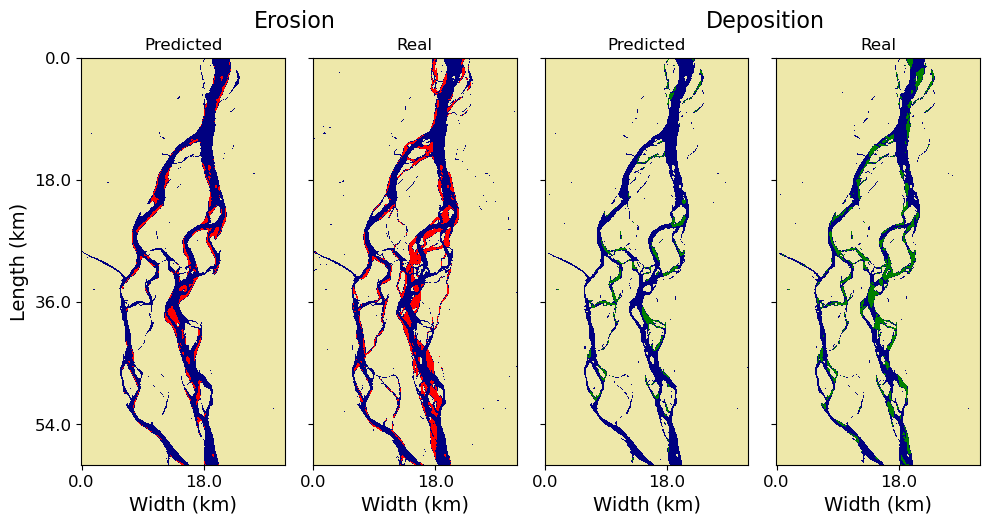

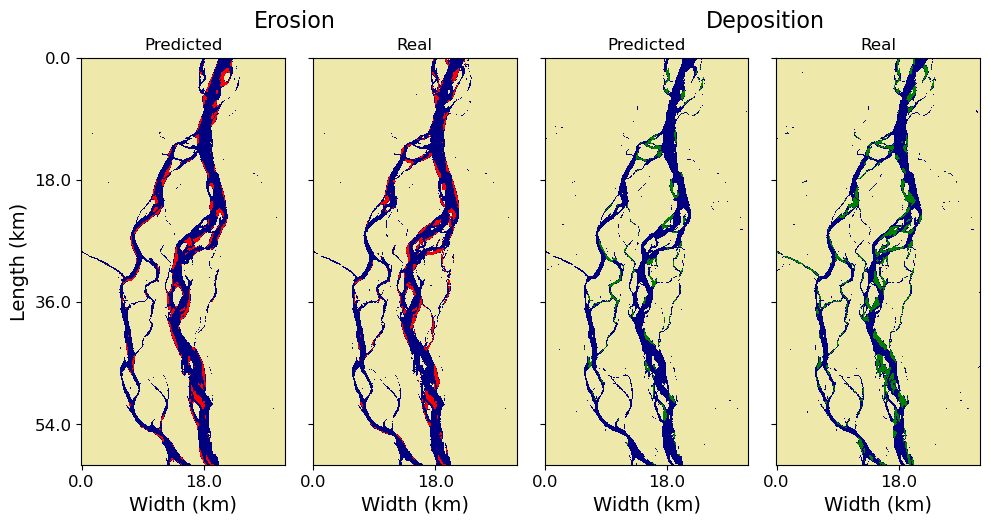

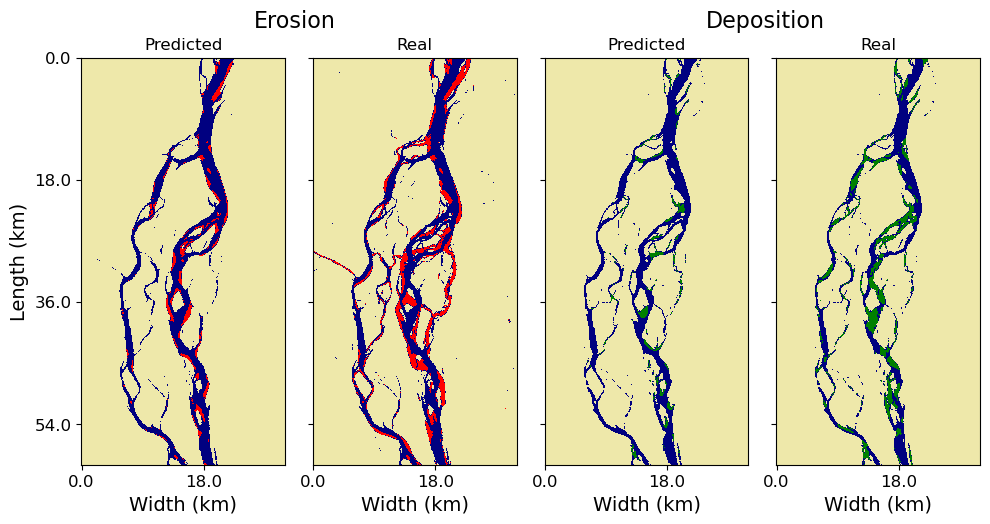

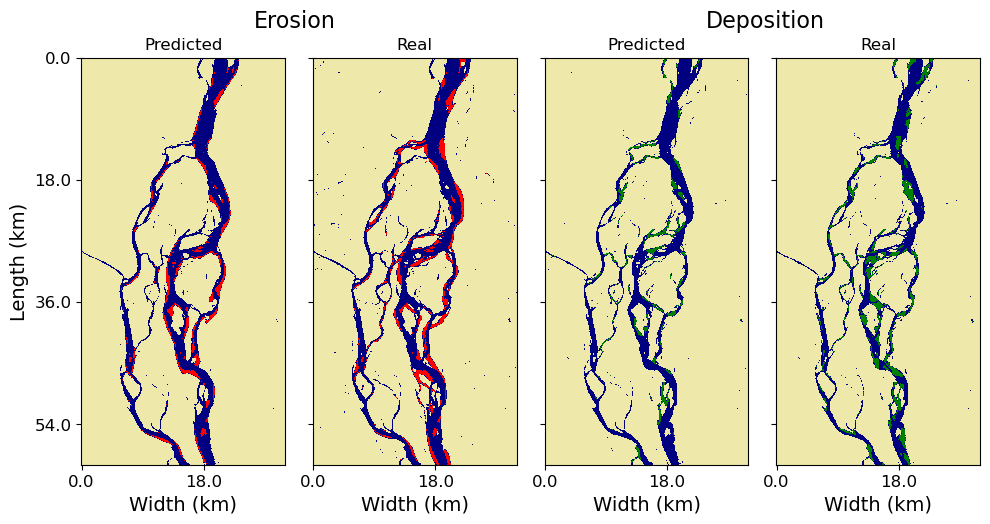

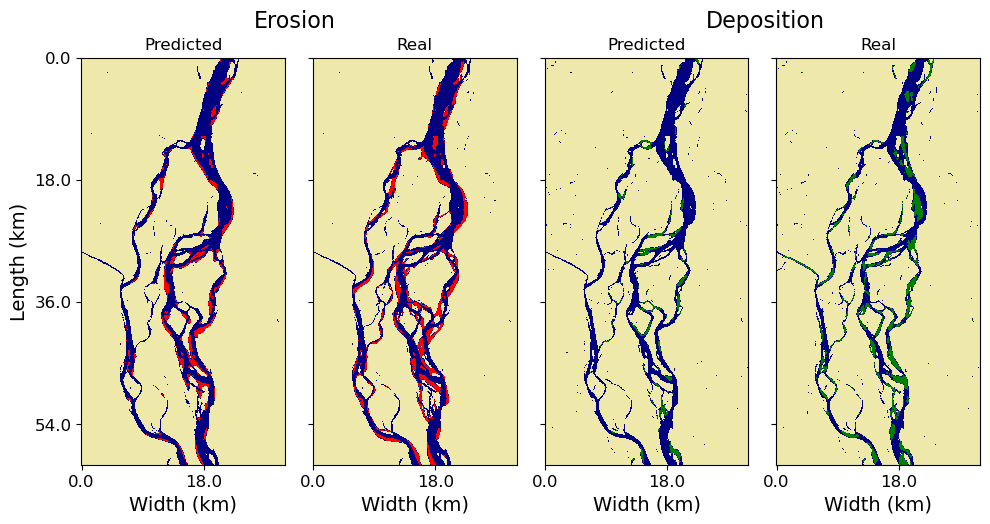

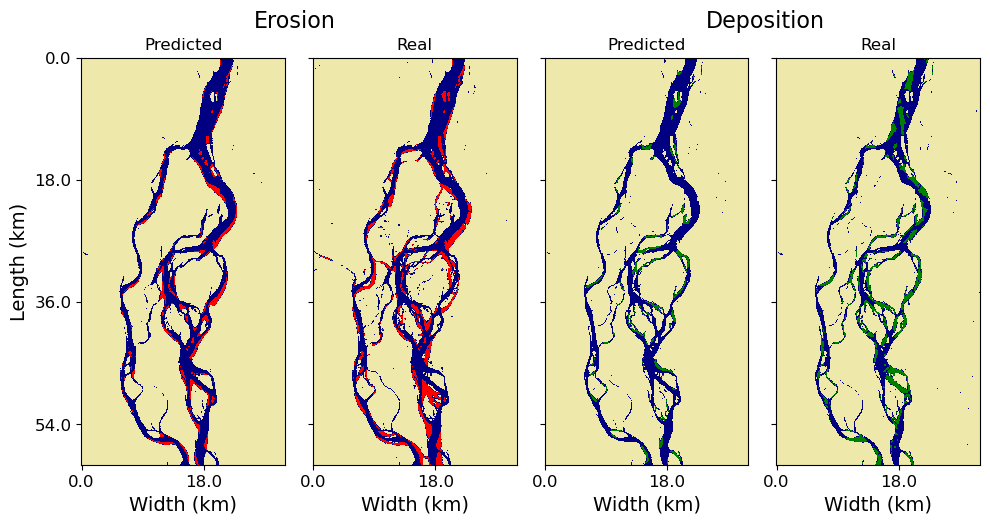

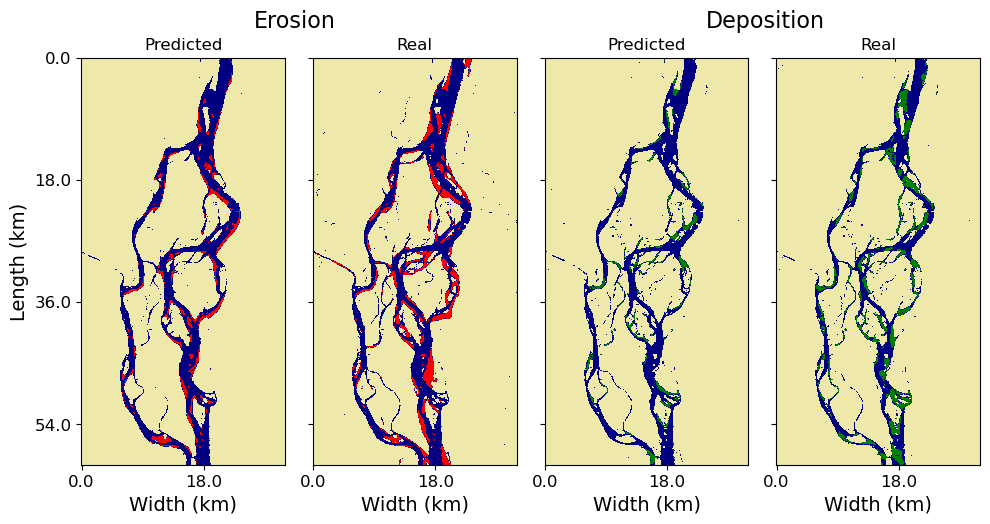

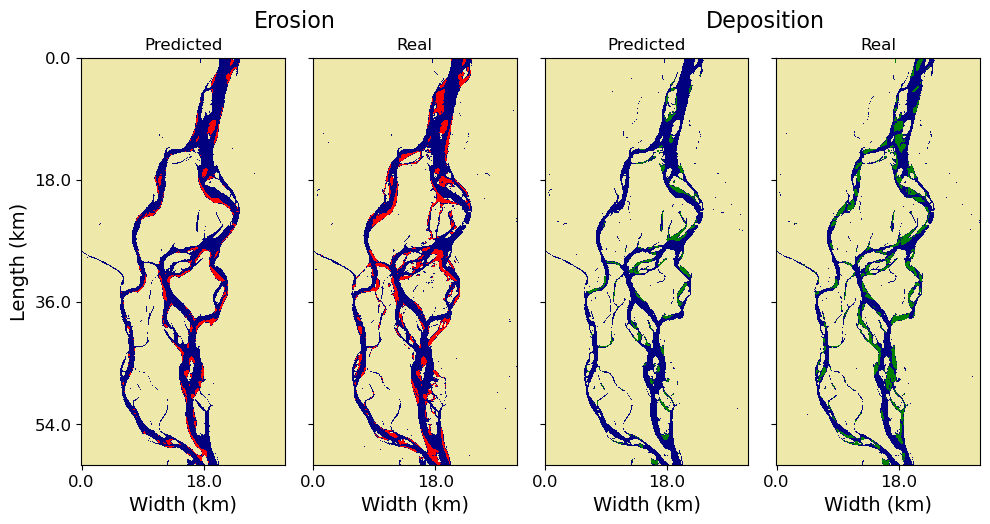

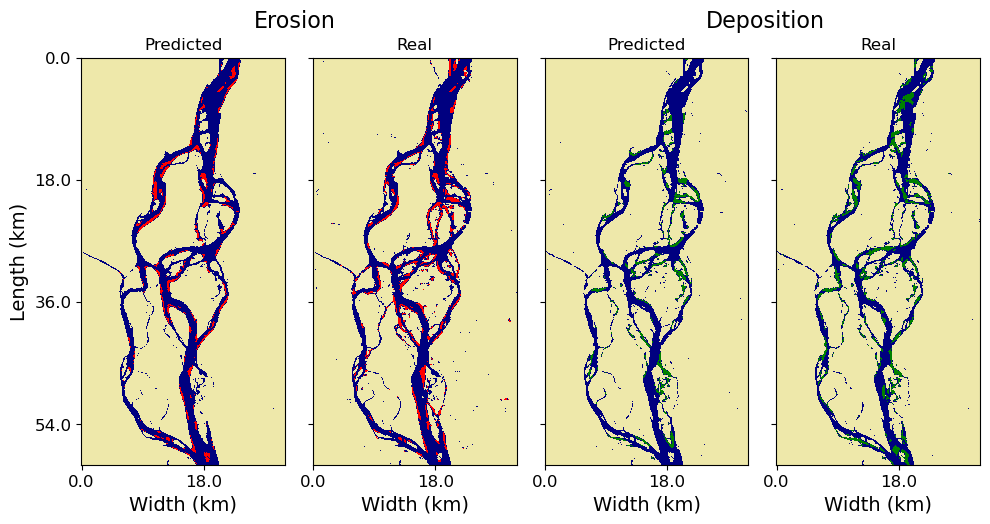

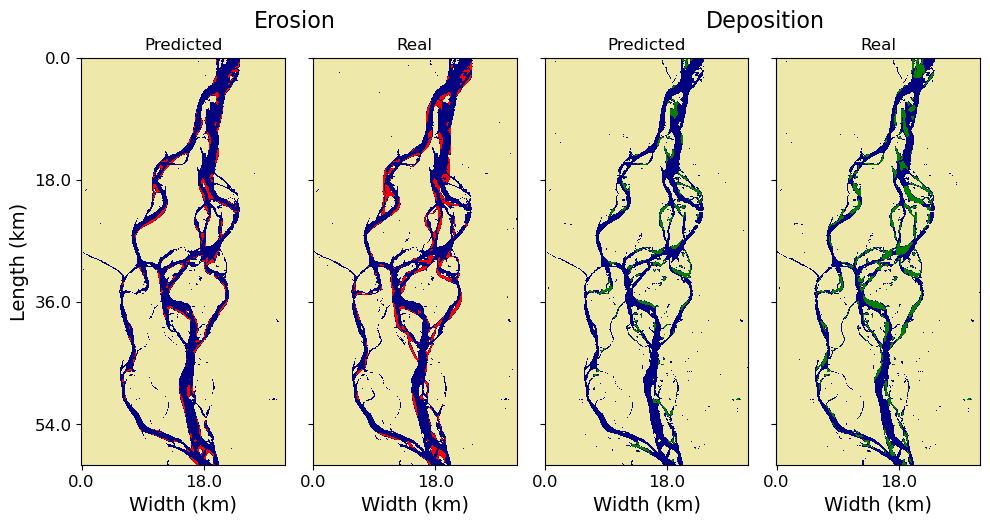

In [22]:
%matplotlib inline
for i in range(len(test_set)):
    erosion_sites(model_loss, test_set, i, device=device, save_img=False)

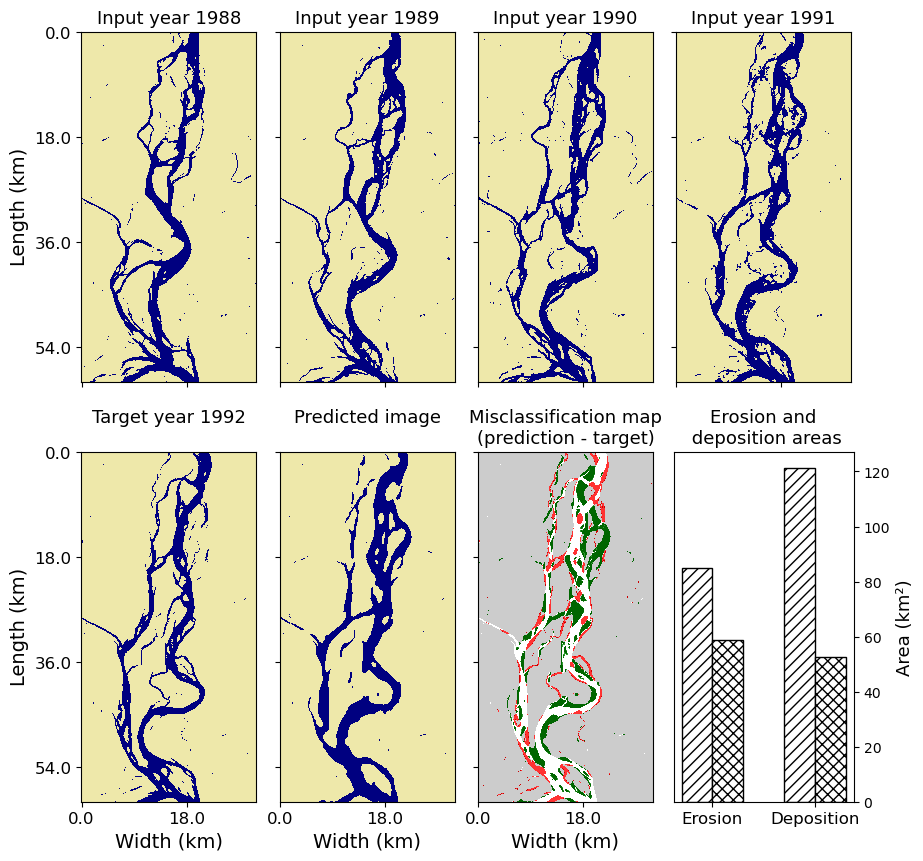

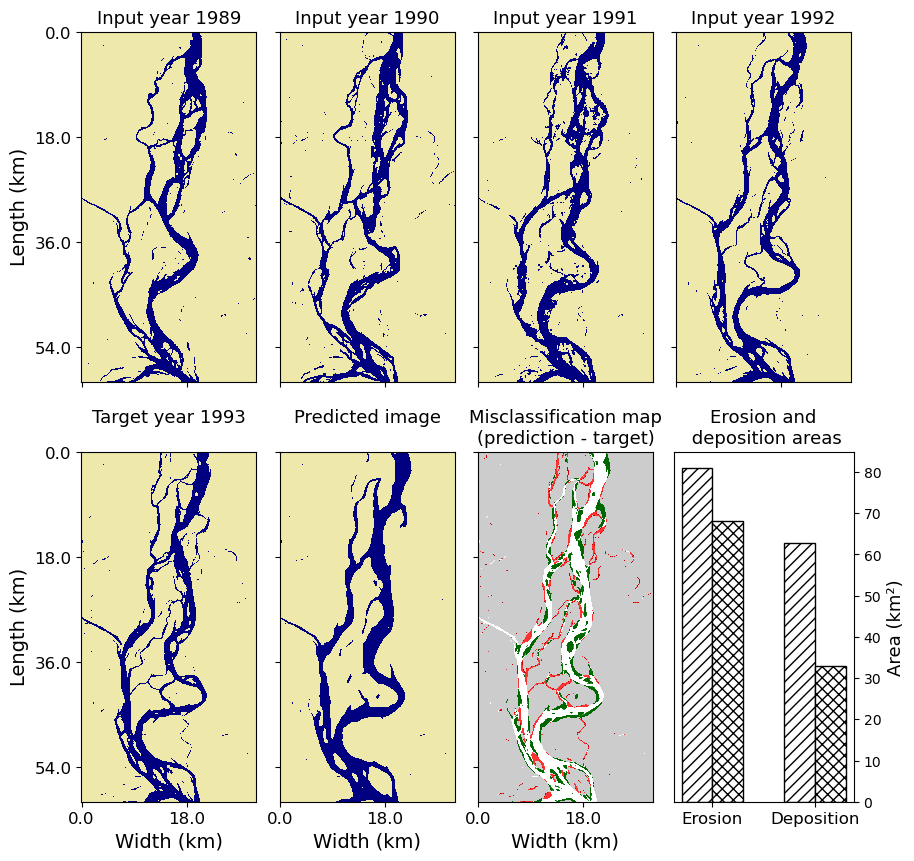

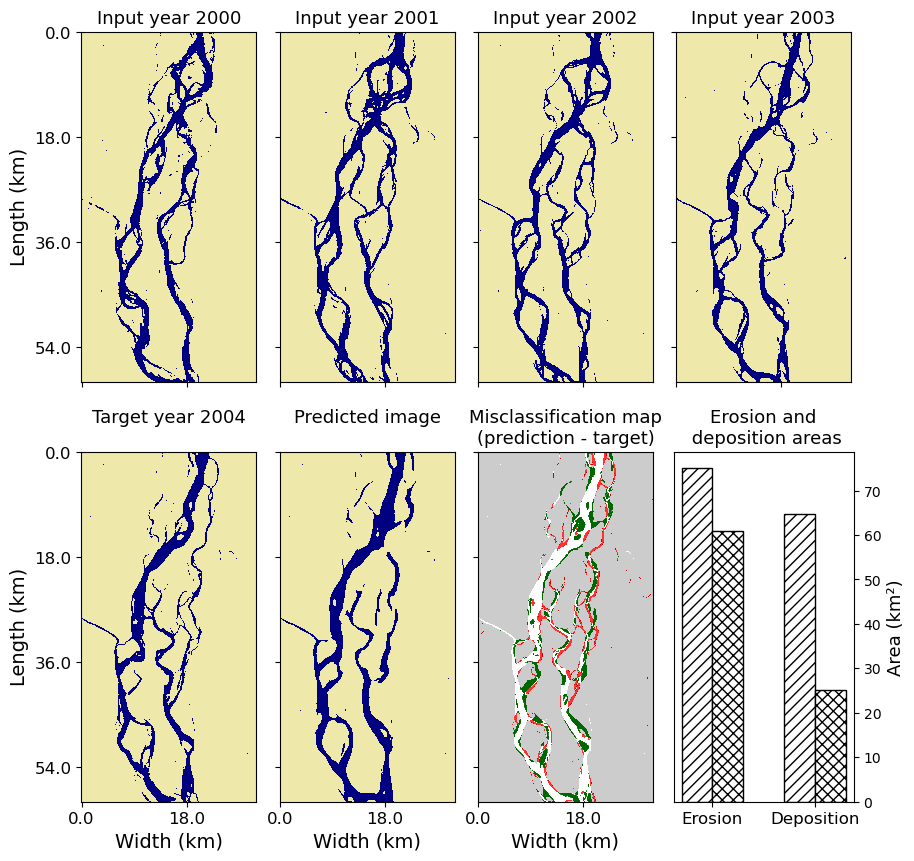

In [25]:
# visualise min loss model predictions with optimal threshold

%matplotlib inline
for i in range(3):
    show_evolution_nolegend(i, test_set, model_loss, water_threshold=new_thr, loss_recall='min loss_0.4', device=device, save_img=False)

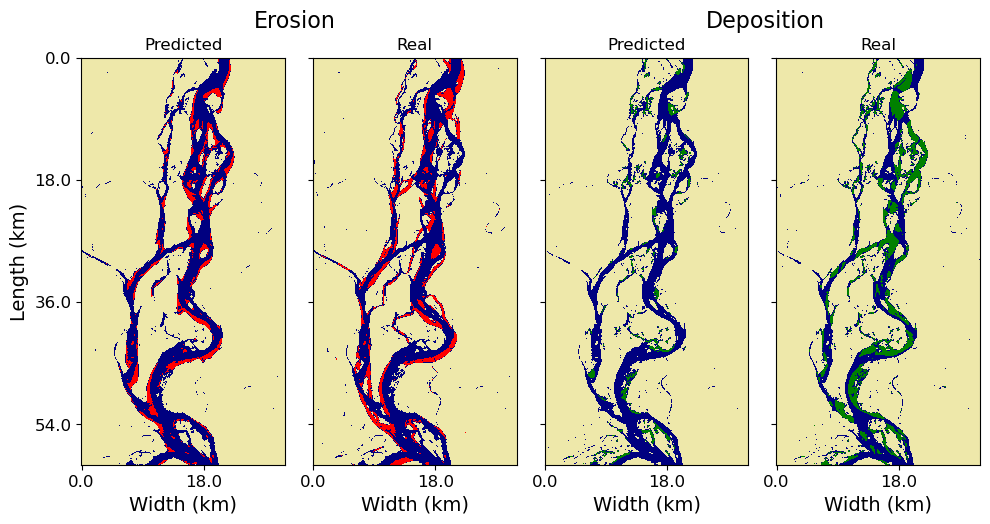

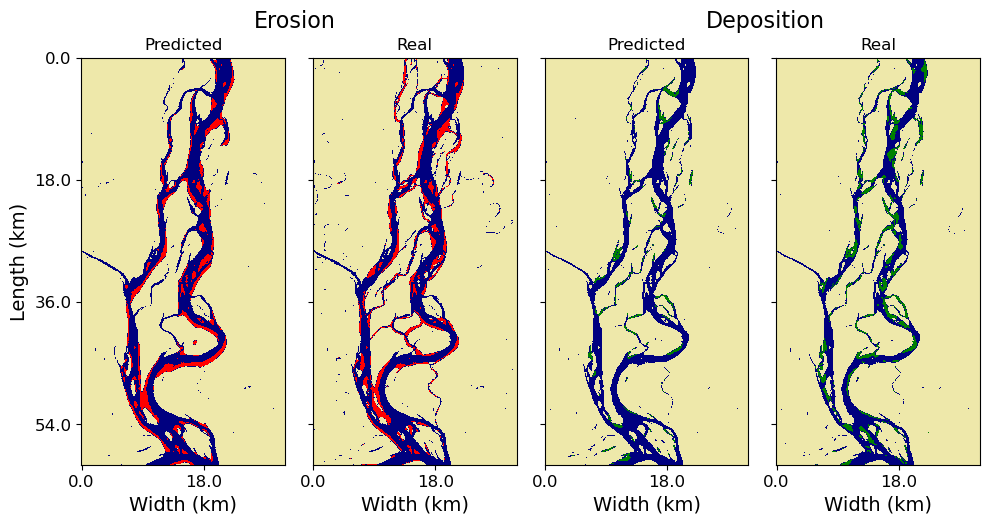

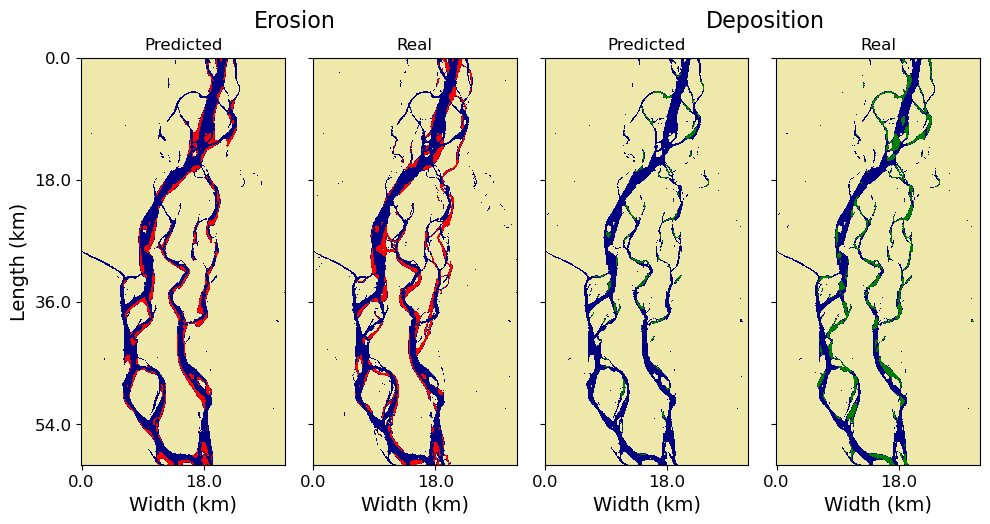

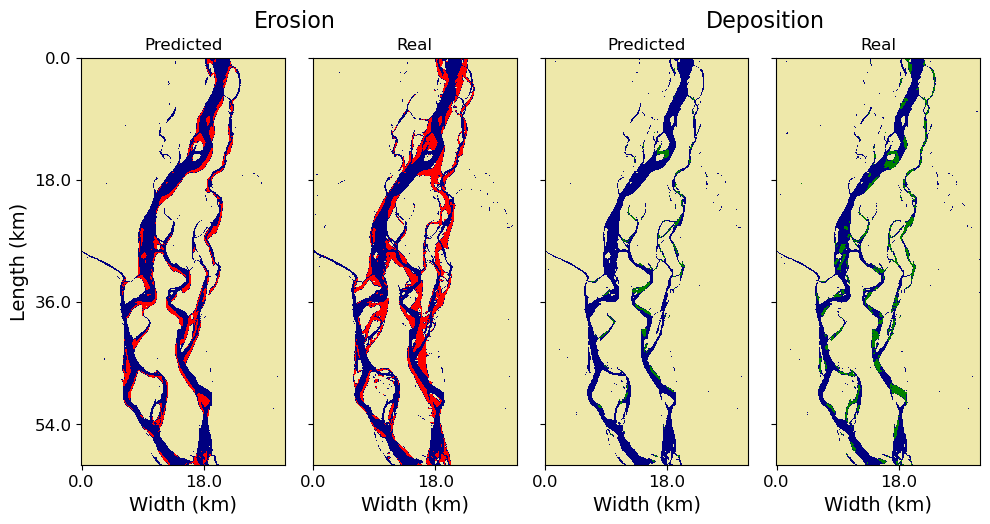

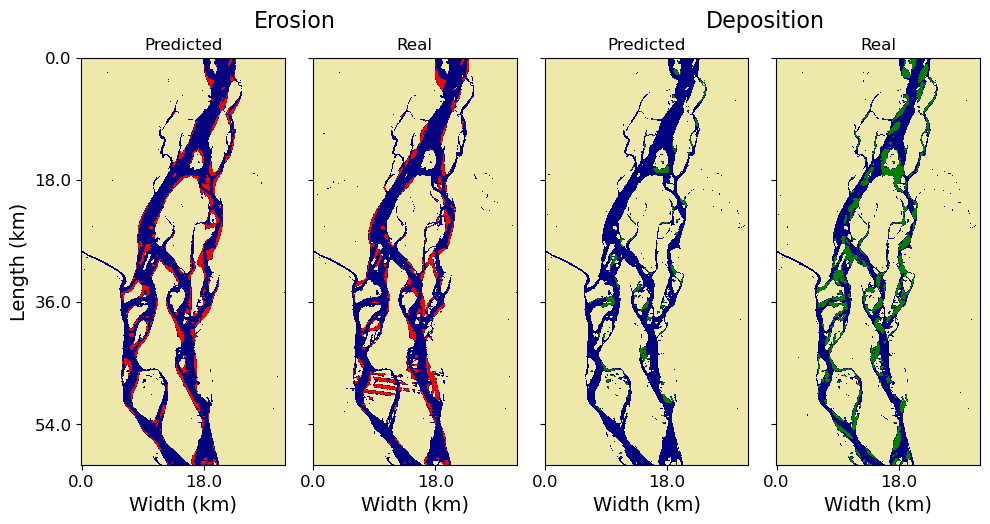

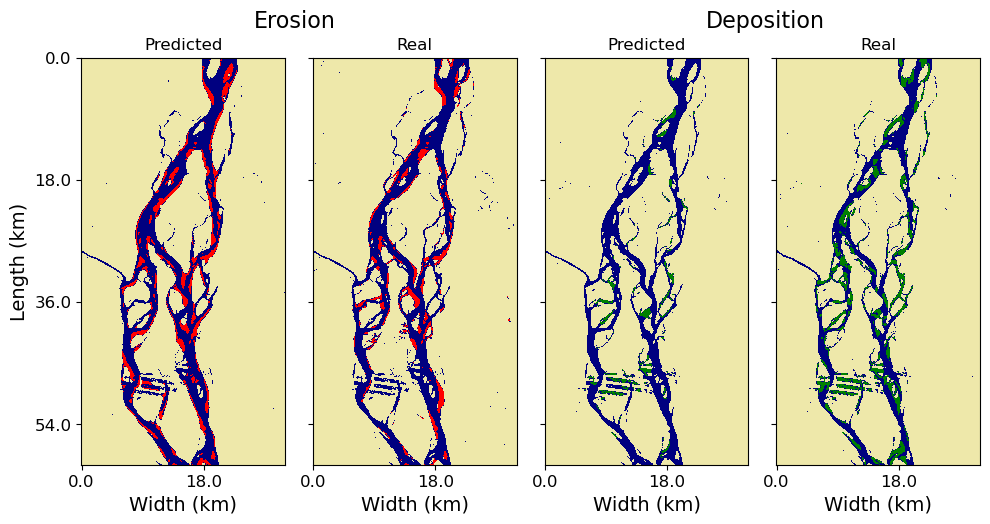

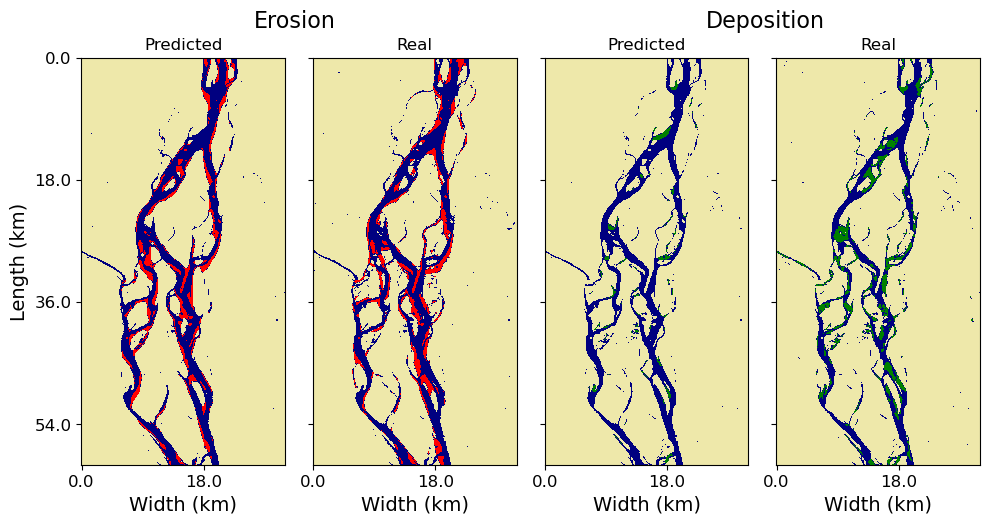

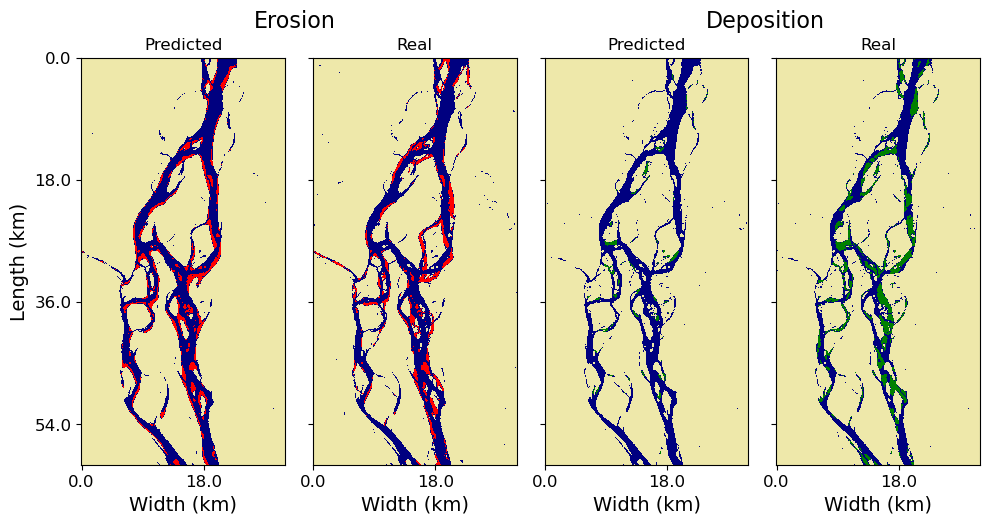

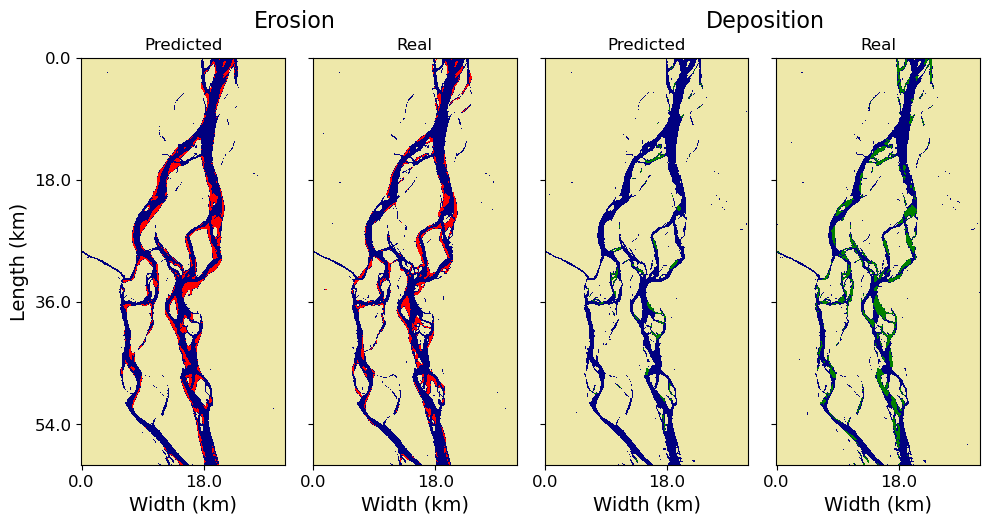

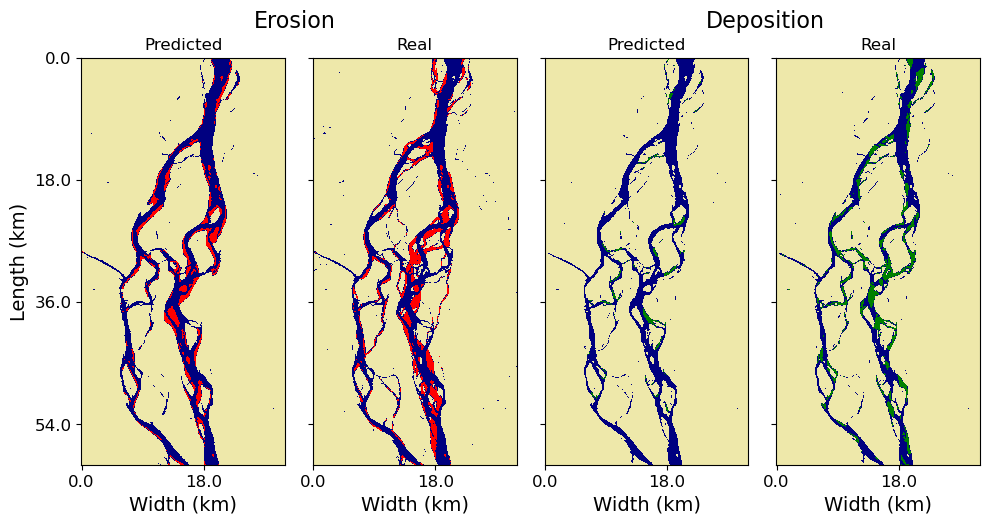

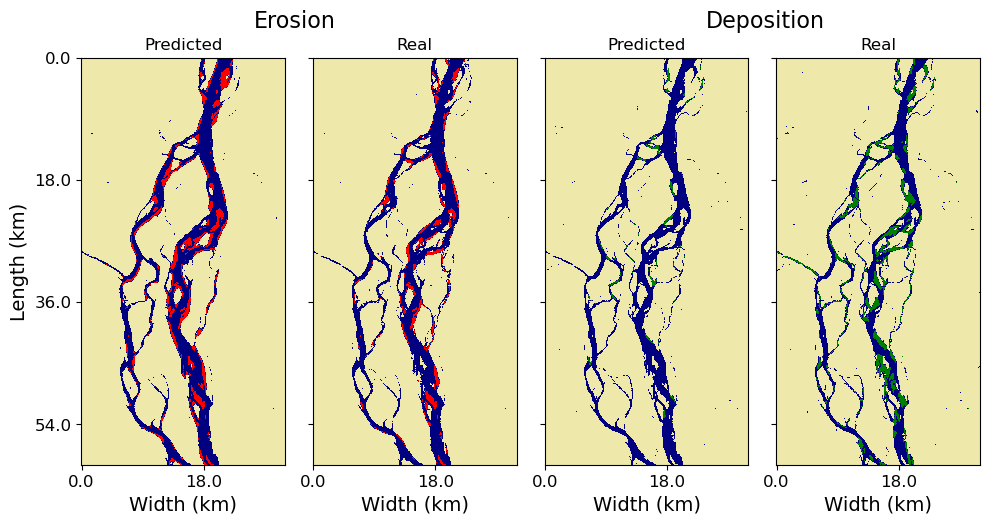

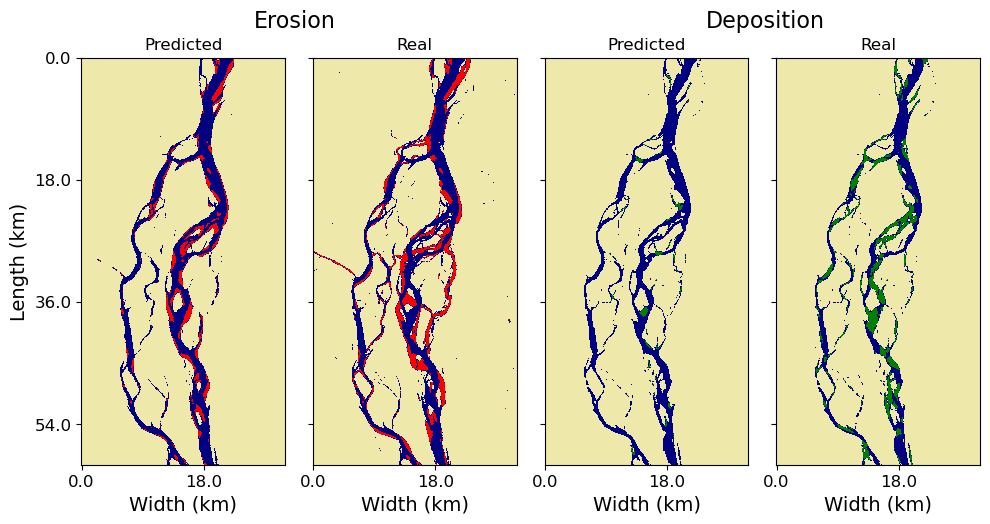

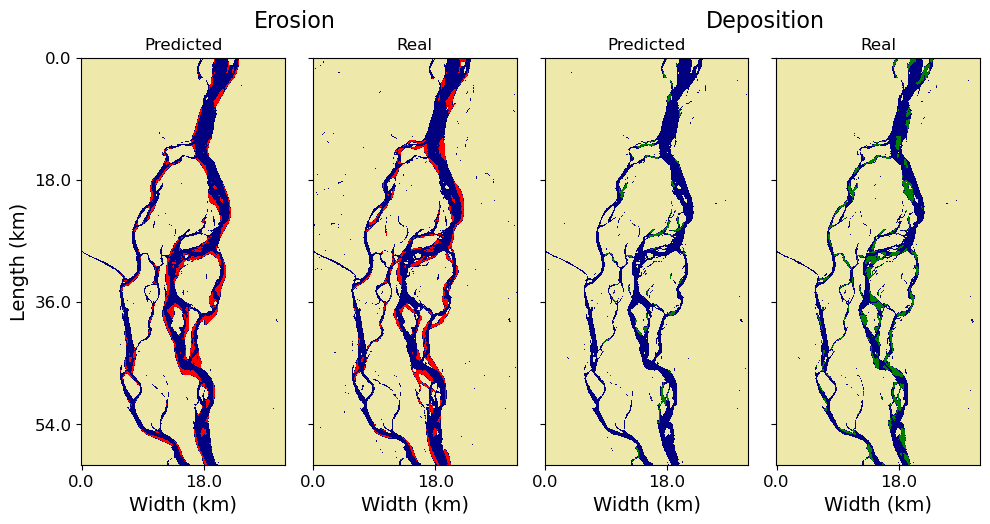

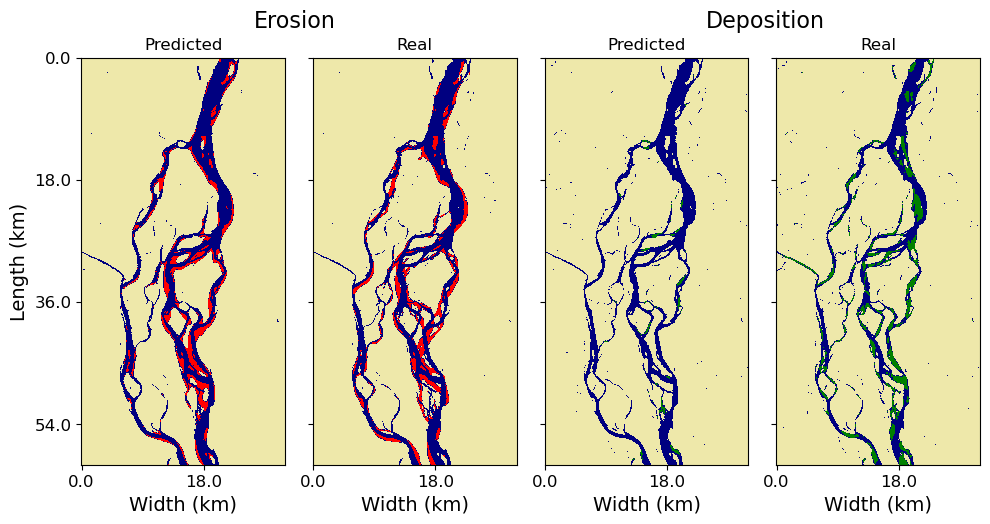

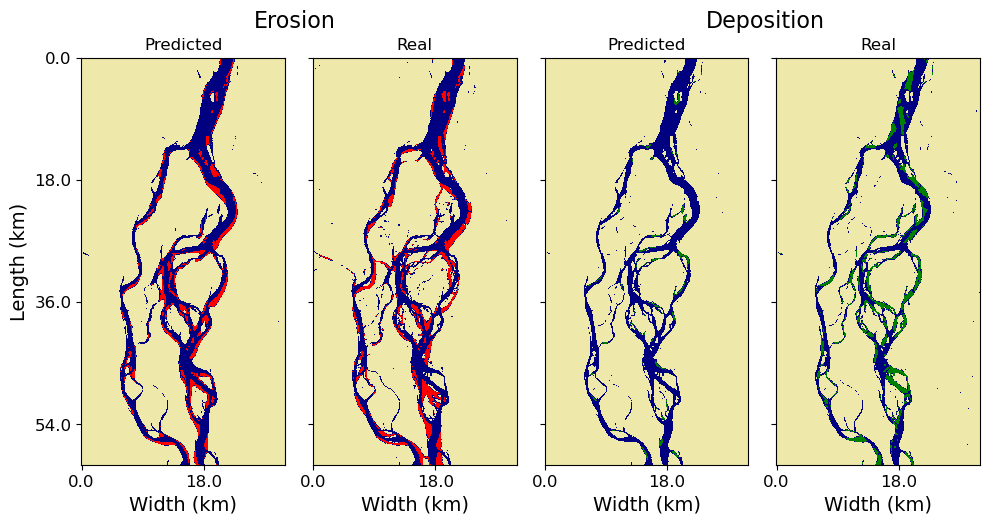

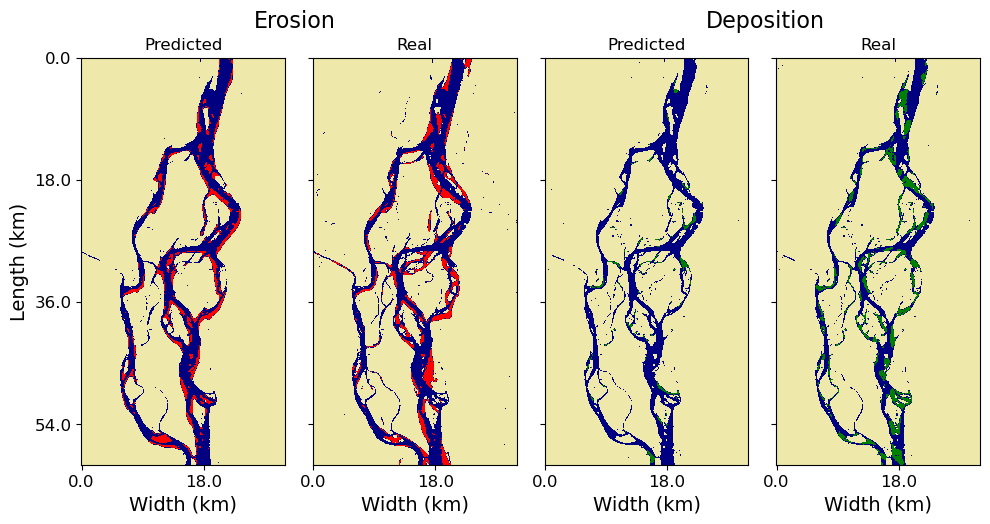

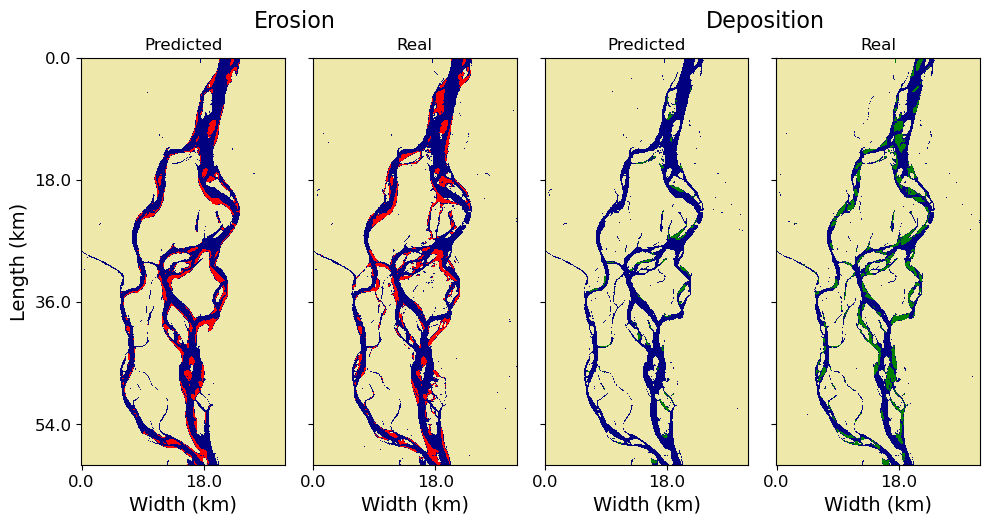

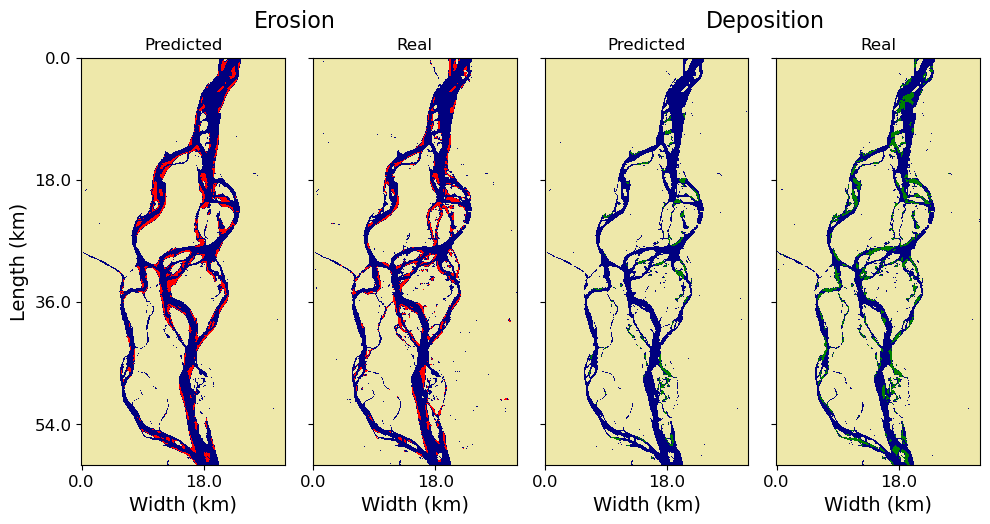

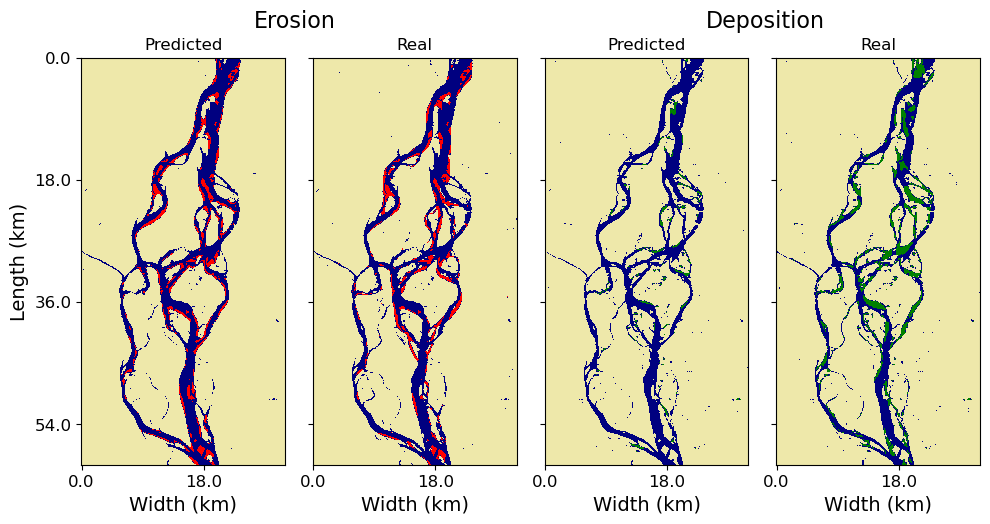

In [24]:
%matplotlib inline
for i in range(len(test_set)):
    erosion_sites(model_loss, test_set, i, water_threshold=new_thr, device=device, save_img=False)

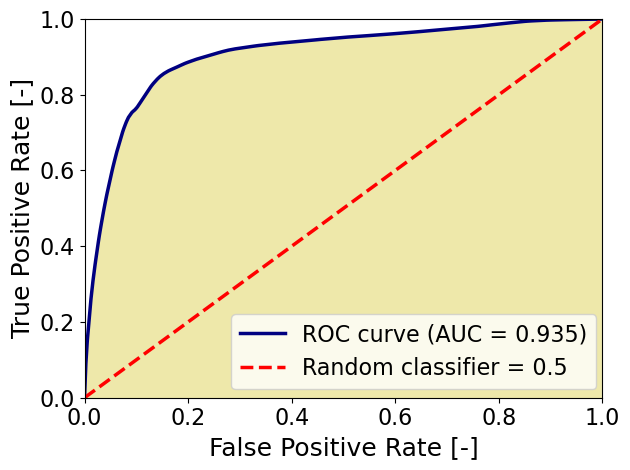

In [32]:
%matplotlib inline
get_total_roc_curve(model_loss, test_set, device=device, save_img=False)

/workspace/jamunet-morpho-braided/postprocessing/metrics.py:193: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/workspace/jamunet-morpho-braided/postprocessing/metrics.py:193: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/workspace/jamunet-morpho-braided/postprocessing/metrics.py:193: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/workspace/jamunet-morpho-braided/postprocessing/metrics.py:193: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/workspace/jamunet-morpho-braided/postprocessing/metrics.py:193: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


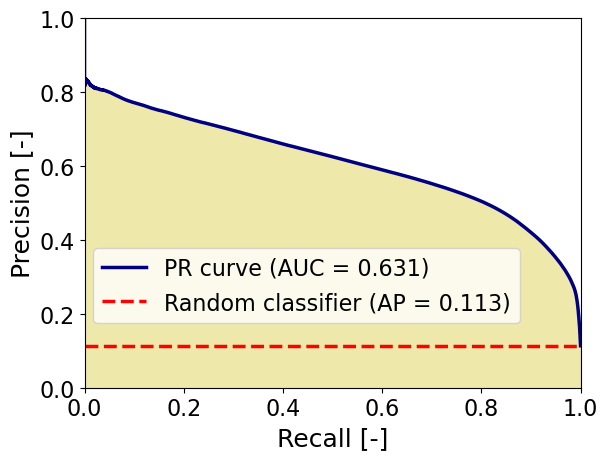

In [33]:
%matplotlib inline
get_total_pr_curve(model_loss, test_set, device=device, save_img=False);

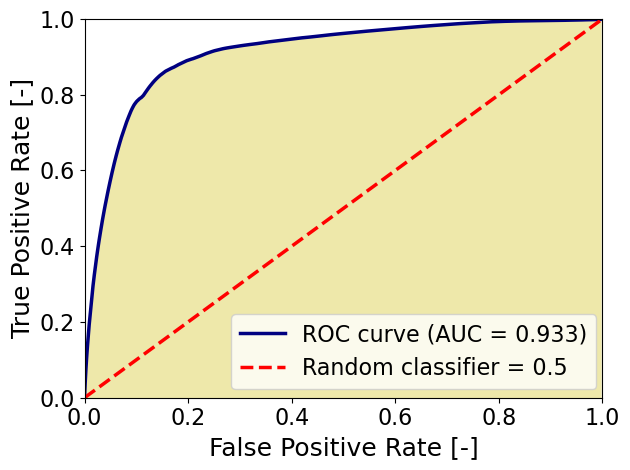

In [34]:
%matplotlib inline
get_total_roc_curve(model_recall, test_set, model_type='max recall', device=device, save_img=True)

/workspace/jamunet-morpho-braided/postprocessing/metrics.py:193: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/workspace/jamunet-morpho-braided/postprocessing/metrics.py:193: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/workspace/jamunet-morpho-braided/postprocessing/metrics.py:193: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/workspace/jamunet-morpho-braided/postprocessing/metrics.py:193: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


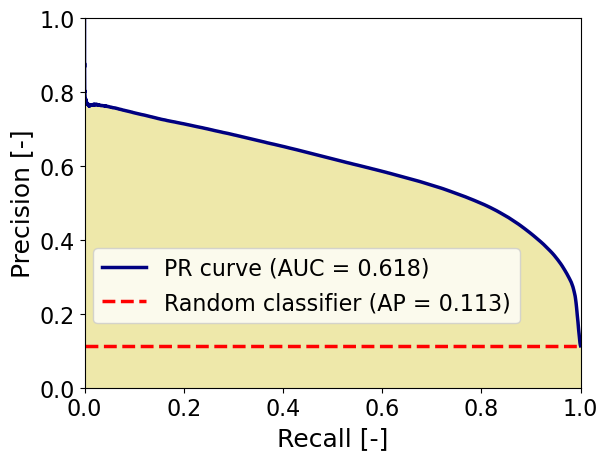

In [35]:
%matplotlib inline
get_total_pr_curve(model_recall, test_set, model_type='max recall', device=device, save_img=True);

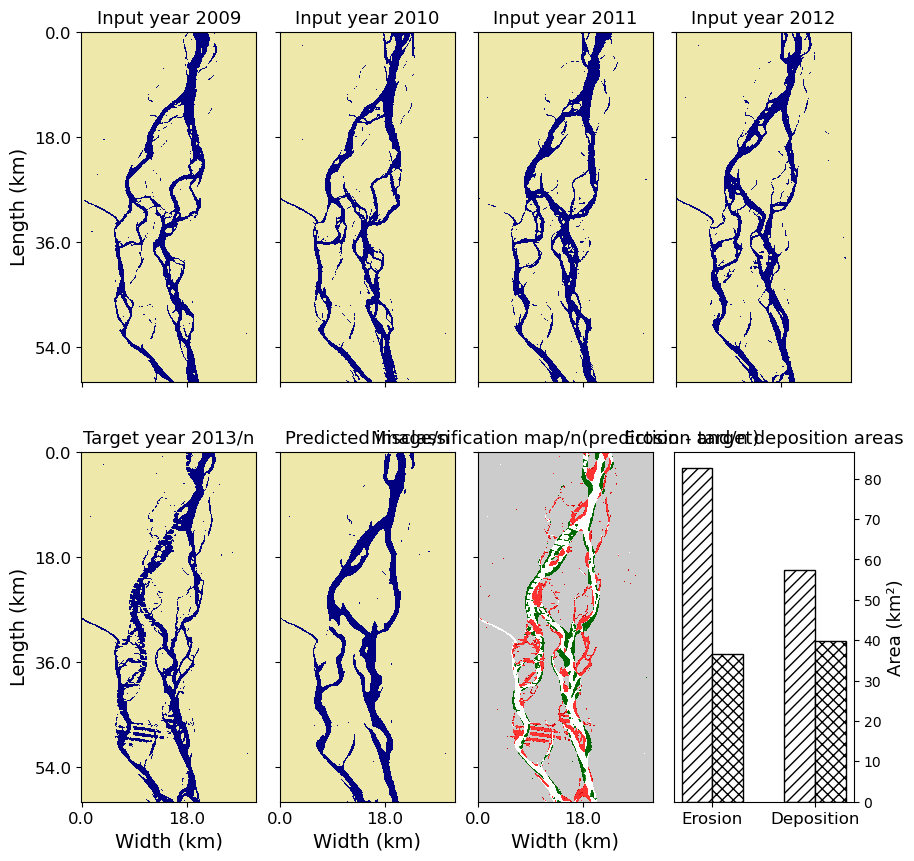

In [36]:
# direct comparison of same sample predictions with original threshold (0.5) and optimal threshold (0.402) 

%matplotlib inline
show_evolution_nolegend(11, test_set, model_loss, device=device, save_img=False)

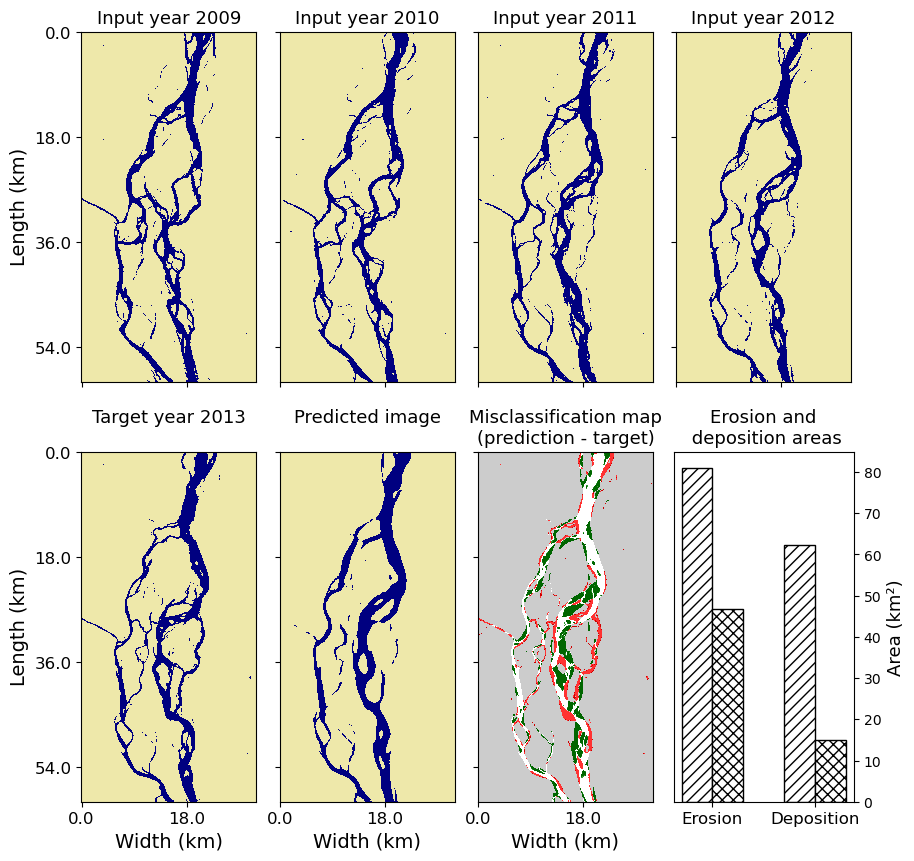

In [33]:
%matplotlib inline
show_evolution_nolegend(11, test_set, model_loss, water_threshold=new_thr, device=device, save_img=False)

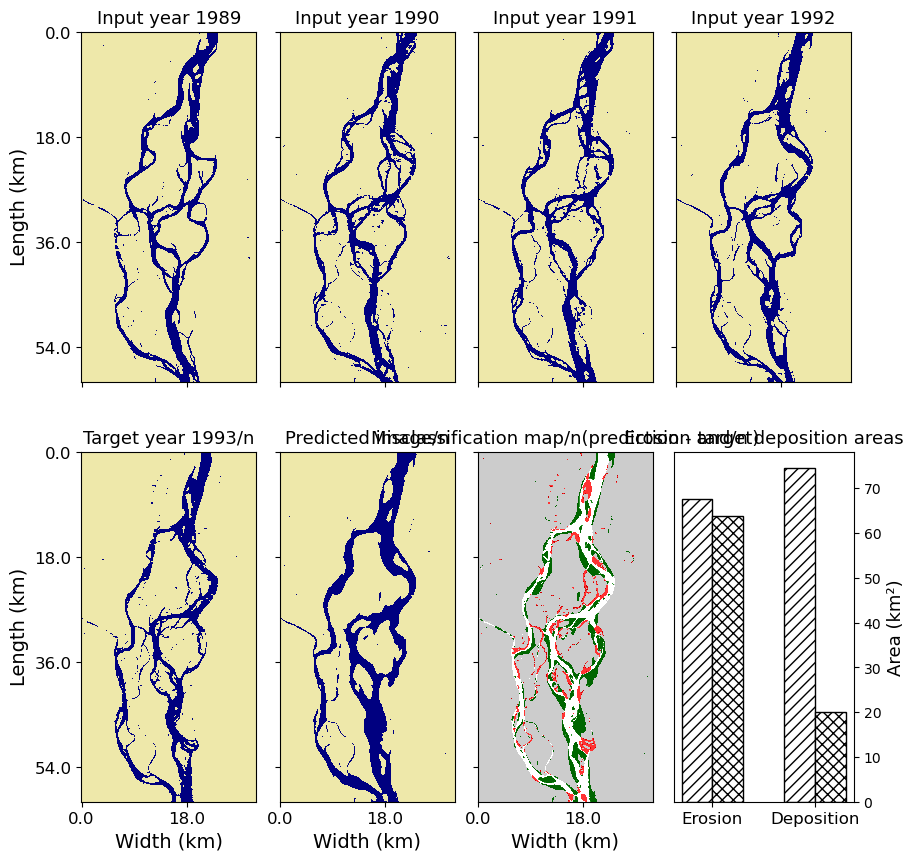

In [40]:
# max recall model predictions

%matplotlib inline
show_evolution_nolegend(1, test_set, model_recall, loss_recall='max recall', device=device, save_img=True)

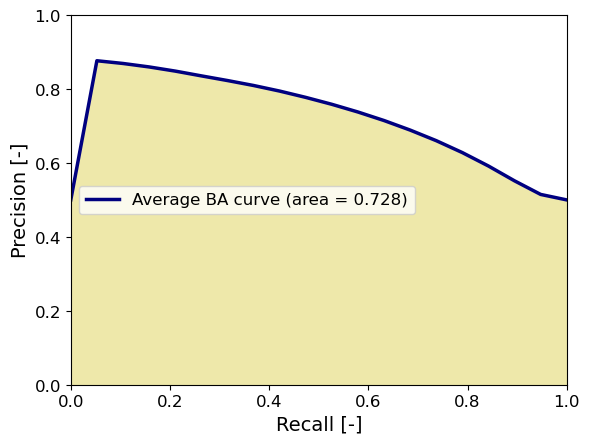

In [41]:
get_total_balanced_accuracy(model_loss, test_set, device=device, save_img=True)

In [42]:
# min loss model

%matplotlib inline
plot_dataset_losses_metrics(model_loss, test_set, device=device, save_img=True) 

TypeError: total_losses_metrics_dataset() got an unexpected keyword argument 'overall'

In [ ]:
%matplotlib inline
box_plots(model_loss, test_set, device=device, save_img=True)

In [ ]:
# max recall model
%matplotlib inline
plot_dataset_losses_metrics(model_recall, test_set, model_type='max recall', device=device, save_img=True) 

In [ ]:
%matplotlib inline
box_plots(model_recall, test_set, model_type='max recall', device=device, save_img=True)

In [ ]:
%matplotlib inline
correlation_metrics(model_loss, test_set, device=device, save_img=True)

In [ ]:
%matplotlib inline
metrics_thresholds(model_loss, test_loader, device=device, save_img=True)

In [ ]:
%matplotlib inline
correlation_erdep(model_loss, test_set, device=device, save_img=True)

In [ ]:
%matplotlib inline
erosion_deposition_distribution(model_loss, test_set, device=device, save_img=True)

In [ ]:
%matplotlib inline
correlation_erdep(model_recall, test_set, model_type='max_recall', device=device, save_img=True)

In [ ]:
%matplotlib inline
erosion_deposition_distribution(model_recall, test_set, model_type='max_recall', device=device, save_img=True)